# By-phone error rates: Buckeye test set
This computes and compares error rates and confusion matrices at the phone level across different models' predicted transcriptions in the Buckeye test set on a reduced symbol set. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.


In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phonecodes import phonecodes
import seaborn as sns

from multipa.evaluation import ModelEvaluator, PREDICTION_KEY, EPS, compute_error_rate_confidence_intervals_df
from multipa.evaluation_extras import greedy_reduction_find_and_replace, TIMIT_AND_OTHER_REDUCED_MAPPING, BUCKEYE_REDUCED_MAPPING
from multipa.visualization import plot_error_rates_by_phone_and_model, plot_token_confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

TOKEN_ANALYSIS_OUTPUT = "buckeye_test_token_analysis.csv"
DETAILED_EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")

POST_PROCESS_OUT_DIR = "by_phone_error_rates_post_proc"
# These are the models we're actually interested in evaluating in detail
OUR_EVAL_CSVS = [
    # Models trained on full 20K samples (full dataset but gender balanced)
    "data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Models trained on entire dataset
    "ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
]

OUR_CSVS_WITH_MAPPING = [(csv, BUCKEYE_REDUCED_MAPPING) for csv in OUR_EVAL_CSVS]

# Third party comparison models - these are the models that performed best on Buckeye from each group
EXTERNAL_EVAL_CSVS = [
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified_detailed_predictions.csv",
]

EXTERNAL_CSVS_WITH_MAPPING = [(csv, TIMIT_AND_OTHER_REDUCED_MAPPING) for csv in EXTERNAL_EVAL_CSVS]

# Valid Buckeye token set
VALID_BUCKEYE_PHONES = set(phonecodes.phonecode_tables._buckeye2ipa.values())

# Note: This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
# Nasalized vowels shouldn't show up after post-processing, but we'll leave them in so that we
# can make sure they're actually being removed
BUCKEYE_VOWELS = set(["ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "ɹ̩", "eɪ", "ɪ", "i", "oʊ", "ɔɪ", "ʊ", "u", "æ̃", "ɔ̃",
                  "ə̃", "ĩ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ɑ̃", "ũ", "ɾ̃", "ə", "ɛ̃", "ʊ̃", "ãʊ̃", "ʌ̃", "ɪ̃", "ɹ̩̃", "ɔ̃ɪ̃"])

BUCKEYE_CONSONANTS = VALID_BUCKEYE_PHONES - BUCKEYE_VOWELS

# I'm just being picky about plot colors
# This is for "model_group" column
HUE_ORDER = ["Buckeye fine-tuned on full train split", #"full_dataset_train",
             "Buckeye fine-tuned on full gender balanced train set", #"train_duration_20000_samples",
             "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified",
             "openai_whisper-medium.en_to_epitran",
             "facebook_wav2vec2-lv-60-espeak-cv-ft",
             "allosaurus_eng2102_eng",
             "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns"
]

REFERENCE_COL = "ipa"

HUE_ORDER_INDEX = {key: i for i, key in enumerate(HUE_ORDER)}

PALETTE = "colorblind"

sns.set_palette(PALETTE)

def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, VALID_BUCKEYE_PHONES)

def get_model_group(model_name):
    if model_name.startswith("train_duration_20000_samples"):
        return "Buckeye fine-tuned on full gender balanced train set"
    elif model_name.startswith("full_dataset_train"):
        return "Buckeye fine-tuned on full train split"
    return model_name


/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Phonecodes transforms")
for k, v in phonecodes.phonecode_tables._buckeye2ipa.items():
    print(k, ":", v, [hex(ord(c)) for c in v])

Phonecodes transforms
AA : ɑ ['0x251']
AE : æ ['0xe6']
AH : ʌ ['0x28c']
AO : ɔ ['0x254']
AW : aʊ ['0x61', '0x28a']
AY : aɪ ['0x61', '0x26a']
EH : ɛ ['0x25b']
ER : ɹ̩ ['0x279', '0x329']
EY : eɪ ['0x65', '0x26a']
IH : ɪ ['0x26a']
IY : i ['0x69']
OW : oʊ ['0x6f', '0x28a']
OY : ɔɪ ['0x254', '0x26a']
UH : ʊ ['0x28a']
UW : u ['0x75']
B : b ['0x62']
CH : tʃ ['0x74', '0x283']
D : d ['0x64']
DH : ð ['0xf0']
EL : l̩ ['0x6c', '0x329']
EM : m̩ ['0x6d', '0x329']
EN : n̩ ['0x6e', '0x329']
F : f ['0x66']
G : ɡ ['0x261']
HH : h ['0x68']
JH : dʒ ['0x64', '0x292']
K : k ['0x6b']
L : l ['0x6c']
M : m ['0x6d']
N : n ['0x6e']
NG : ŋ ['0x14b']
P : p ['0x70']
R : ɹ ['0x279']
S : s ['0x73']
SH : ʃ ['0x283']
T : t ['0x74']
TH : θ ['0x3b8']
V : v ['0x76']
W : w ['0x77']
Y : j ['0x6a']
Z : z ['0x7a']
ZH : ʒ ['0x292']
AEN : æ̃ ['0xe6', '0x303']
AON : ɔ̃ ['0x254', '0x303']
AXN : ə̃ ['0x259', '0x303']
IYN : ĩ ['0x69', '0x303']
EYN : ẽɪ̃ ['0x65', '0x303', '0x26a', '0x303']
OWN : õʊ̃ ['0x6f', '0x303', '0x28a', '0x

In [3]:
print("Buckeye transform")
for k, v in BUCKEYE_REDUCED_MAPPING.items():
    print(k, [hex(ord(c)) for c in k], ":", v)

Buckeye transform
ãʊ̃ ['0x61', '0x303', '0x28a', '0x303'] : aʊ
ẽɪ̃ ['0x65', '0x303', '0x26a', '0x303'] : eɪ
õʊ̃ ['0x6f', '0x303', '0x28a', '0x303'] : oʊ
ãɪ̃ ['0x61', '0x303', '0x26a', '0x303'] : aɪ
ɔ̃ɪ̃ ['0x254', '0x303', '0x26a', '0x303'] : ɔɪ
æ̃ ['0xe6', '0x303'] : æ
ɔ̃ ['0x254', '0x303'] : ɔ
ə̃ ['0x259', '0x303'] : ə
ĩ ['0x69', '0x303'] : i
ɑ̃ ['0x251', '0x303'] : ɑ
ũ ['0x75', '0x303'] : u
ɛ̃ ['0x25b', '0x303'] : ɛ
ʊ̃ ['0x28a', '0x303'] : ʊ
ɪ̃ ['0x26a', '0x303'] : ɪ
ɹ̩̃ ['0x279', '0x329', '0x303'] : ɹ̩
β ['0x3b2'] : f
ɾ̃ ['0x27e', '0x303'] : n
ʌ̃ ['0x28c', '0x303'] : ə
ʌ ['0x28c'] : ə
õ ['0x6f', '0x303'] : o
ĩ ['0x129'] : i
ã ['0xe3'] : a


# Post-process predictions and evaluations
Read in evaluation results, tokenize, and calculate token counts and edit distance errors for each model. 


In [4]:
# Read in model results and re-generate comparison metrics
out_dir = Path(POST_PROCESS_OUT_DIR)
out_dir.mkdir(exist_ok=True)

MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":buckeye_merge_func})

# Will use to make a dataframe that we can pivot to compare model vocabulary by token counts
# in Buckeye test set predictions across models
model_token_counts = []
model_names = []
display_names = []

for (csv, token_mapping) in OUR_CSVS_WITH_MAPPING + EXTERNAL_CSVS_WITH_MAPPING:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()

    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    print("Model name:", model_name)
    model_names.append(model_name)
    # Normalize prediction according to model-specific mapping
    # TODO use IPA tok normalization to clean things up
    model_results[PREDICTION_KEY] = model_results[PREDICTION_KEY].apply(lambda x: greedy_reduction_find_and_replace(x, token_mapping))
    # Normalize reference according to Buckeye reduced symbol set
    latest_ref_col = model_results[REFERENCE_COL].apply(lambda x: greedy_reduction_find_and_replace(x, phonecodes.phonecode_tables.BUCKEYE_IPA_TO_TIMIT_BUCKEYE_SHARED))

    # Check if any replacements might have failed
    prediction_flag = model_results[model_results[PREDICTION_KEY].str.contains("ũ") | model_results[PREDICTION_KEY].str.contains("ĩ") | model_results[PREDICTION_KEY].str.contains("ɝ")][PREDICTION_KEY]
    if prediction_flag.any():
        display(model_results[prediction_flag])


    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)
    MODEL_EVALUATOR.write_edit_distance_results(model_name, out_dir)

    model_token_counts.extend([(model_name, t, c) for t,c in MODEL_EVALUATOR._true_token_counts[model_name].items()])

model_token_counts_df = pd.DataFrame(model_token_counts, columns=["model_name", "token", "count"])

Processing data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_1
Processing data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_2
Processing data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_3
Processing data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_4
Processing data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_5
Processing ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: full_dataset_train_1
Processing ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_pr

In [5]:
display(model_token_counts_df.head())

model_name token  count
0  train_duration_20000_samples_1     f   2363
1  train_duration_20000_samples_1     ɔ   1725
2  train_duration_20000_samples_1     ɹ   6185
3  train_duration_20000_samples_1    aɪ   4216
4  train_duration_20000_samples_1     v   2329

In [6]:
# Sanity check token counts in the gold-standard labels against actual vocabulary
# The invalid token warnings are harmless, it's just removing some "NOISE" and disfluency markers that snuck through
# data preprocessing, but don't affect training
final_token_counts = {t:0 for t in VALID_BUCKEYE_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref, diphthongs=True, merge = buckeye_merge_func))

test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_BUCKEYE_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

print("Full inventory token counts")
display(token_counts_df)

token_counts_df = token_counts_df[token_counts_df["counts"] > 0]
print("Inventory for analysis token counts")
display(token_counts_df)


REMOVING INVALID TOKEN: O b'O'
REMOVING INVALID TOKEN: I b'I'
REMOVING INVALID TOKEN: E b'E'
REMOVING INVALID TOKEN: A b'A'
REMOVING INVALID TOKEN: U b'U'
REMOVING INVALID TOKEN: H b'H'
Full inventory token counts


phone  counts
44     ə   14566
32     ɪ   12506
0      n   11579
45     s    8389
55     ɛ    6901
29     i    6659
8      t    6465
30     ɹ    6185
19     k    5349
53     l    5348
20     m    4917
43     d    4450
46    aɪ    4216
22     ð    3966
48     w    3965
27    oʊ    3912
25     z    3527
57     j    3408
36     æ    3369
59    ɹ̩    3088
2     eɪ    3048
15     b    2968
42     ɾ    2808
38     ɑ    2765
24     p    2530
11     f    2363
7      v    2329
17     u    2326
23     ʔ    2294
33     h    2079
4      ɡ    1876
9      ɔ    1725
49     ŋ    1586
47     θ    1494
61    n̩    1286
54     ʊ    1085
51     ʃ    1071
5     aʊ     998
26    dʒ     923
3     tʃ     918
39    l̩     727
35    m̩     512
58     ʒ     160
13    ɔɪ     115
52  õʊ̃       0
50     β       0
56    ʌ̃       0
60  ẽɪ̃       0
31    ə̃       0
41    æ̃       0
40    ʊ̃       0
37    ɔ̃       0
34  ɔ̃ɪ̃       0
1   ãɪ̃       0
28    ɑ̃       0
21   ɹ̩̃       0
18    ũ       0
16    ɪ̃       0
14     ʌ       0
12    ɾ̃       0
10    ɛ̃       0
6     ĩ       0
62  ãʊ̃       0

Inventory for analysis token counts


phone  counts
44     ə   14566
32     ɪ   12506
0      n   11579
45     s    8389
55     ɛ    6901
29     i    6659
8      t    6465
30     ɹ    6185
19     k    5349
53     l    5348
20     m    4917
43     d    4450
46    aɪ    4216
22     ð    3966
48     w    3965
27    oʊ    3912
25     z    3527
57     j    3408
36     æ    3369
59    ɹ̩    3088
2     eɪ    3048
15     b    2968
42     ɾ    2808
38     ɑ    2765
24     p    2530
11     f    2363
7      v    2329
17     u    2326
23     ʔ    2294
33     h    2079
4      ɡ    1876
9      ɔ    1725
49     ŋ    1586
47     θ    1494
61    n̩    1286
54     ʊ    1085
51     ʃ    1071
5     aʊ     998
26    dʒ     923
3     tʃ     918
39    l̩     727
35    m̩     512
58     ʒ     160
13    ɔɪ     115

In [7]:
# Munge data into dataframe format for analysis
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_BUCKEYE_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

all_error_rates_df = compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")

In [8]:
display(all_error_rates_df.head())

model_name phone  err_rate  \
0  train_duration_20000_samples_1     f  0.089716   
1  train_duration_20000_samples_2     f  0.121879   
2  train_duration_20000_samples_3     f  0.084215   
3  train_duration_20000_samples_4     f  0.081676   
4  train_duration_20000_samples_5     f  0.092679   

                                            model_group  counts  \
0  Buckeye fine-tuned on full gender balanced train set    2363   
1  Buckeye fine-tuned on full gender balanced train set    2363   
2  Buckeye fine-tuned on full gender balanced train set    2363   
3  Buckeye fine-tuned on full gender balanced train set    2363   
4  Buckeye fine-tuned on full gender balanced train set    2363   

   confidence_interval  
0             0.011523  
1             0.013191  
2             0.011197  
3             0.011043  
4             0.011692

# By-token error rates
Display each model's error rates for each token.

<Axes: title={'center': 'Error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

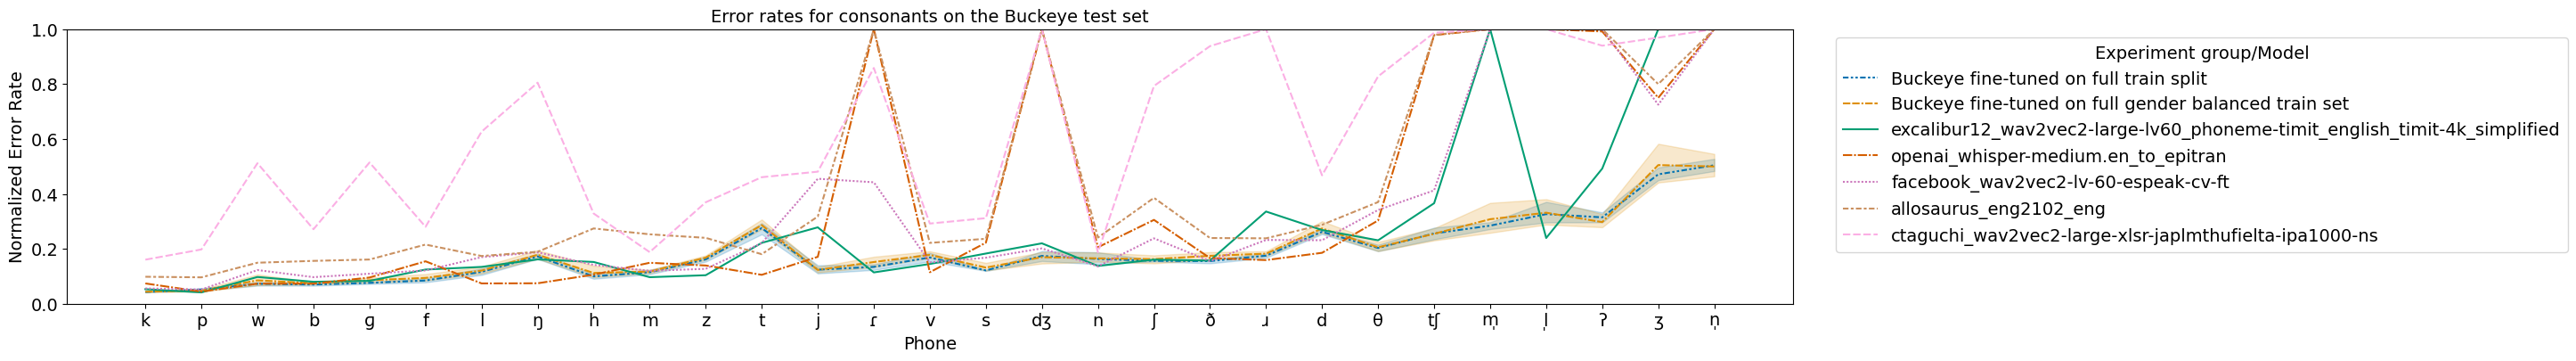

In [9]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(consonant_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'Error rates for vowels on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

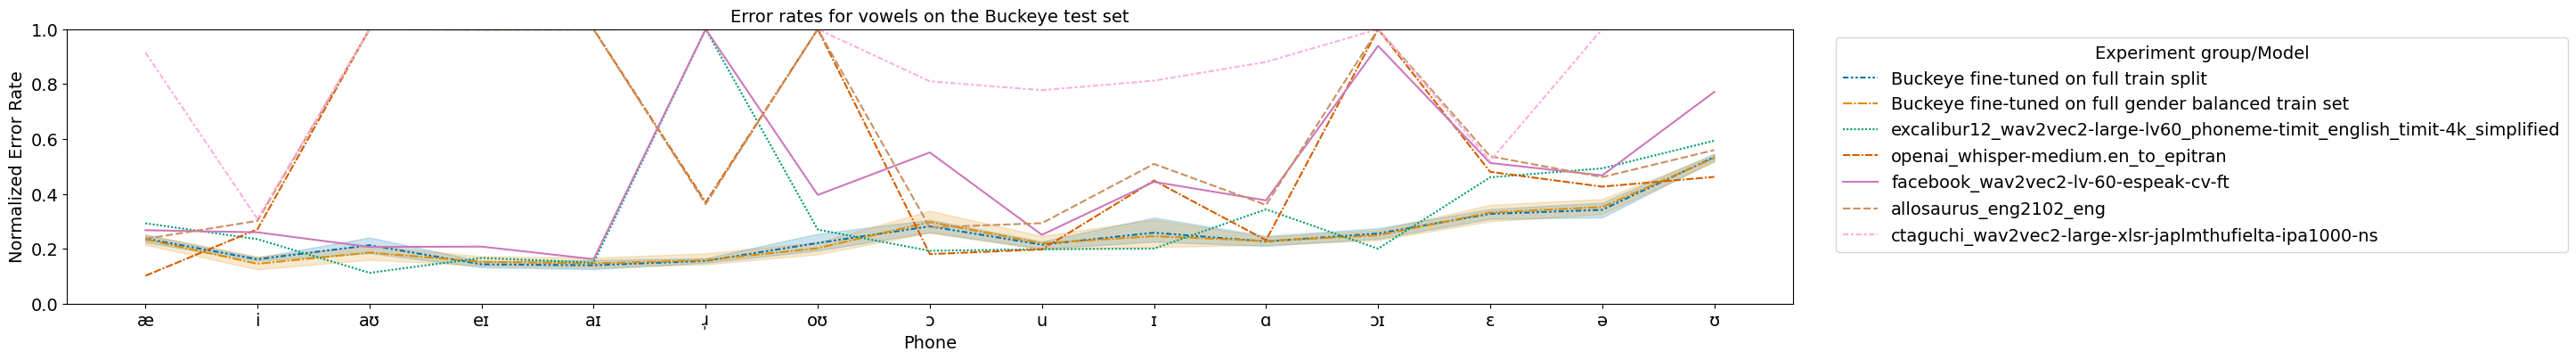

In [10]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(vowel_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for vowels on the Buckeye test set")

In [11]:
our_models = all_error_rates_df[all_error_rates_df["model_group"].isin(["Buckeye fine-tuned on full train split",
             "Buckeye fine-tuned on full gender balanced train set"])]
our_models["display_name"] = our_models["model_name"].apply(lambda x: get_model_group(x) + " " + x[-1:])
model_orders = [f"Buckeye fine-tuned on full train split {i}" for i in range(1, 6)] + [f"Buckeye fine-tuned on full gender balanced train set {i}" for i in range(1, 6)]
display(our_models.head())

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_46258/2803480292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_models["display_name"] = our_models["model_name"].apply(lambda x: get_model_group(x) + " " + x[-1:])


model_name phone  err_rate  \
0  train_duration_20000_samples_1     f  0.089716   
1  train_duration_20000_samples_2     f  0.121879   
2  train_duration_20000_samples_3     f  0.084215   
3  train_duration_20000_samples_4     f  0.081676   
4  train_duration_20000_samples_5     f  0.092679   

                                            model_group  counts  \
0  Buckeye fine-tuned on full gender balanced train set    2363   
1  Buckeye fine-tuned on full gender balanced train set    2363   
2  Buckeye fine-tuned on full gender balanced train set    2363   
3  Buckeye fine-tuned on full gender balanced train set    2363   
4  Buckeye fine-tuned on full gender balanced train set    2363   

   confidence_interval                                            display_name  
0             0.011523  Buckeye fine-tuned on full gender balanced train set 1  
1             0.013191  Buckeye fine-tuned on full gender balanced train set 2  
2             0.011197  Buckeye fine-tuned on full gender balanced train set 3  
3             0.011043  Buckeye fine-tuned on full gender balanced train set 4  
4             0.011692  Buckeye fine-tuned on full gender balanced train set 5

<Axes: title={'center': 'Model error rates for consonants on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

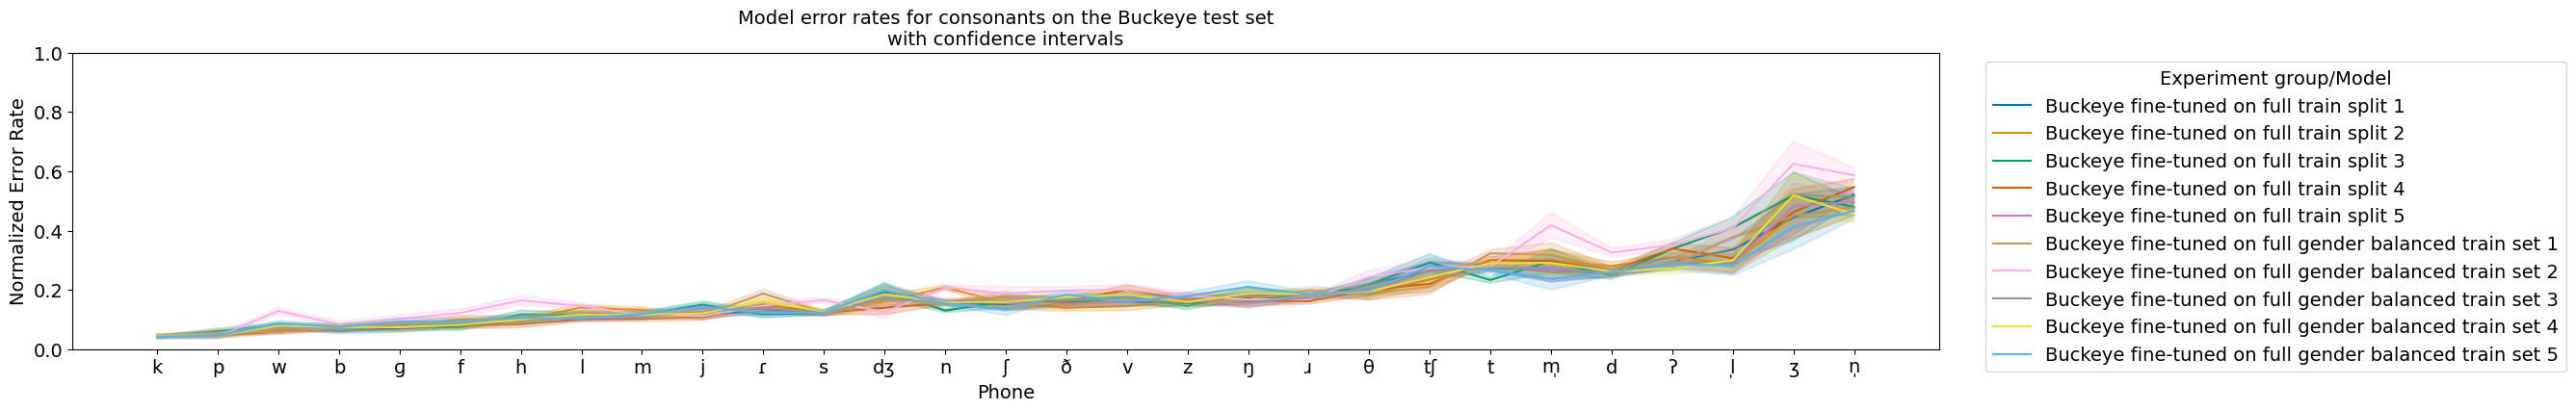

In [12]:
our_models_consonants = our_models[our_models["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(our_models_consonants, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for consonants on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True)

<Axes: title={'center': 'Model error rates for consonants on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

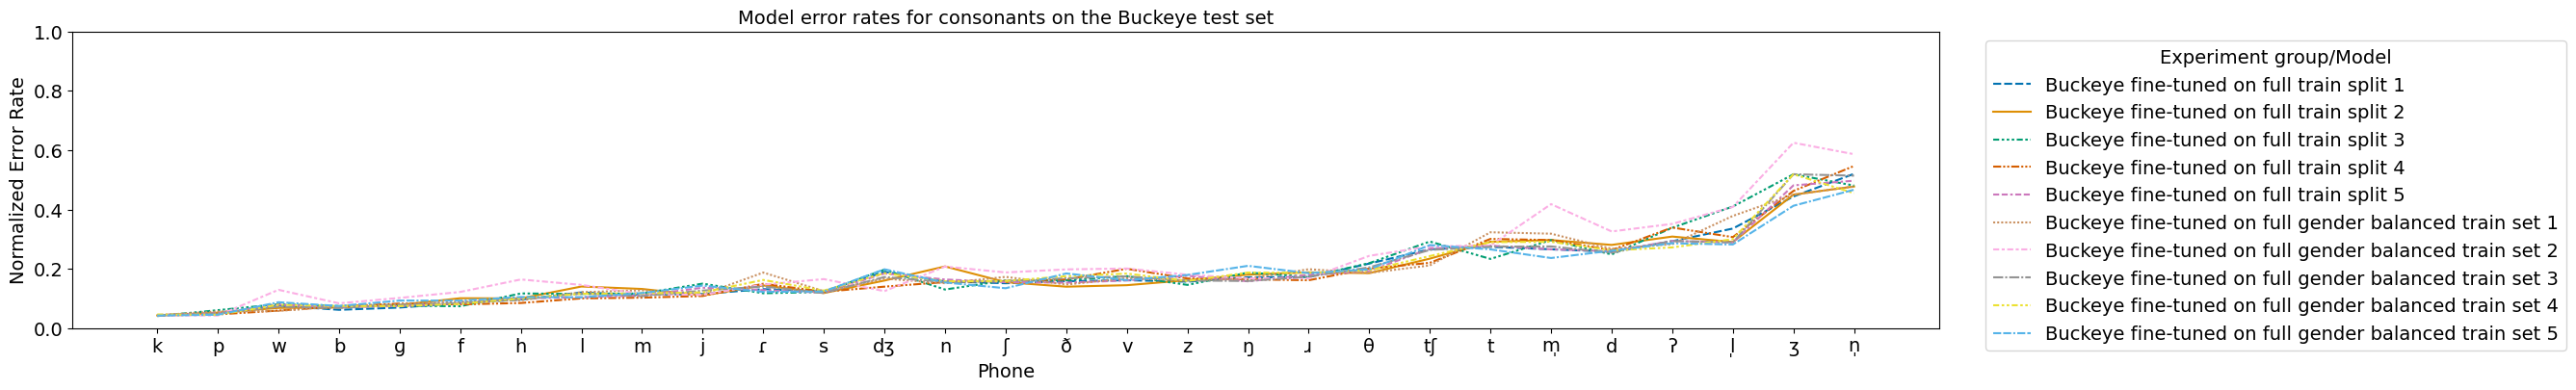

In [13]:
plot_error_rates_by_phone_and_model(our_models_consonants, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for consonants on the Buckeye test set")

<Axes: title={'center': 'Model error rates for vowels on the Buckeye test set\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

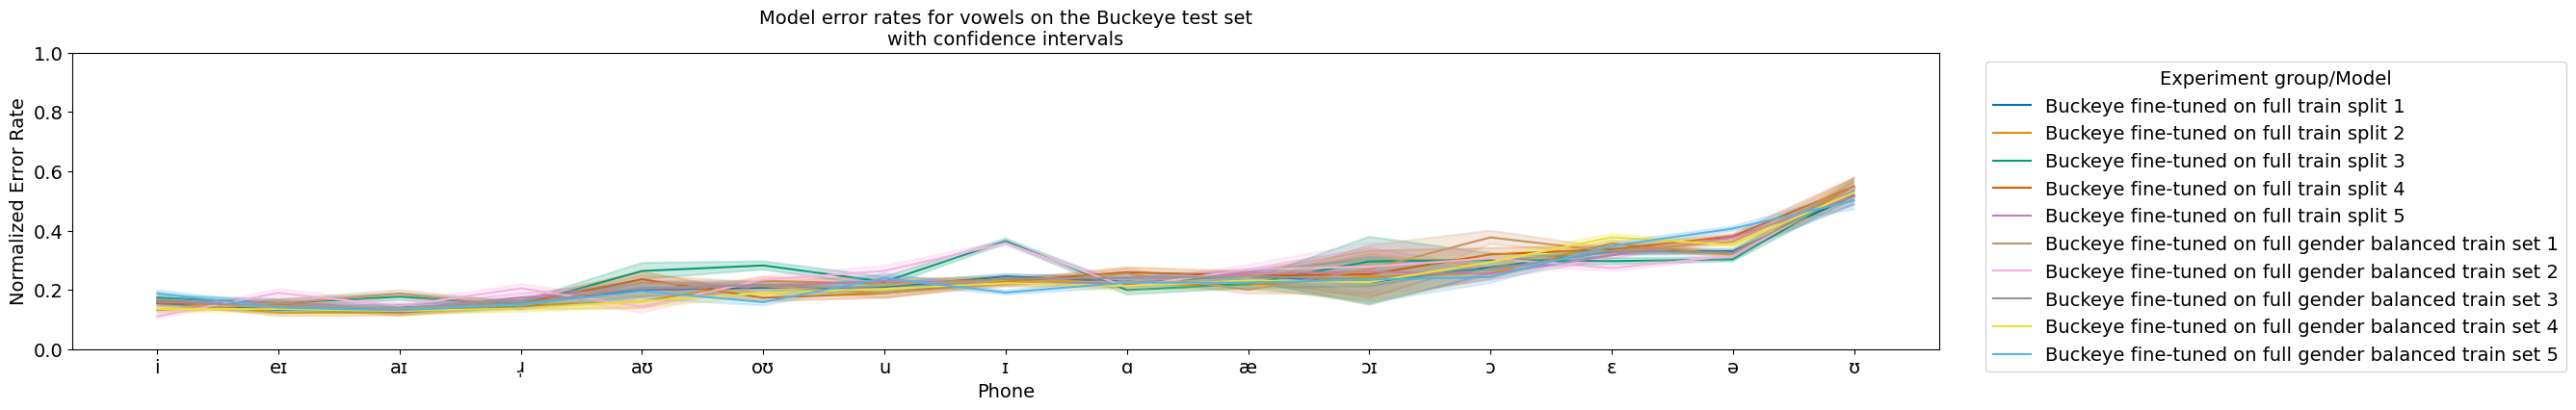

In [14]:
our_models_vowels = our_models[our_models["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(our_models_vowels, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for vowels on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True, )

<Axes: title={'center': 'Model error rates for vowels on the Buckeye test set'}, xlabel='Phone', ylabel='Normalized Error Rate'>

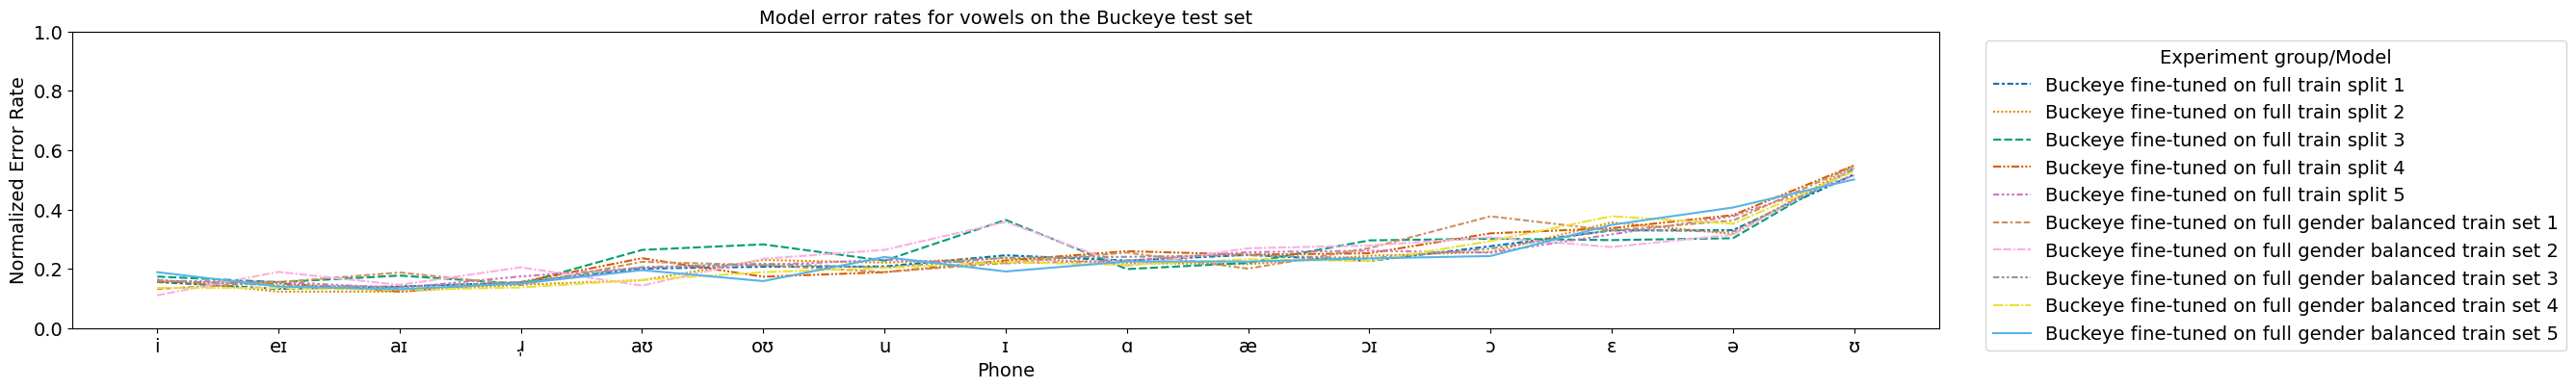

In [15]:
plot_error_rates_by_phone_and_model(our_models_vowels, "display_name", palette=PALETTE, title="Model error rates for vowels on the Buckeye test set", hue_order = model_orders)

<Axes: title={'center': 'Error rates for consonants on the Buckeye test\naveraged across experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

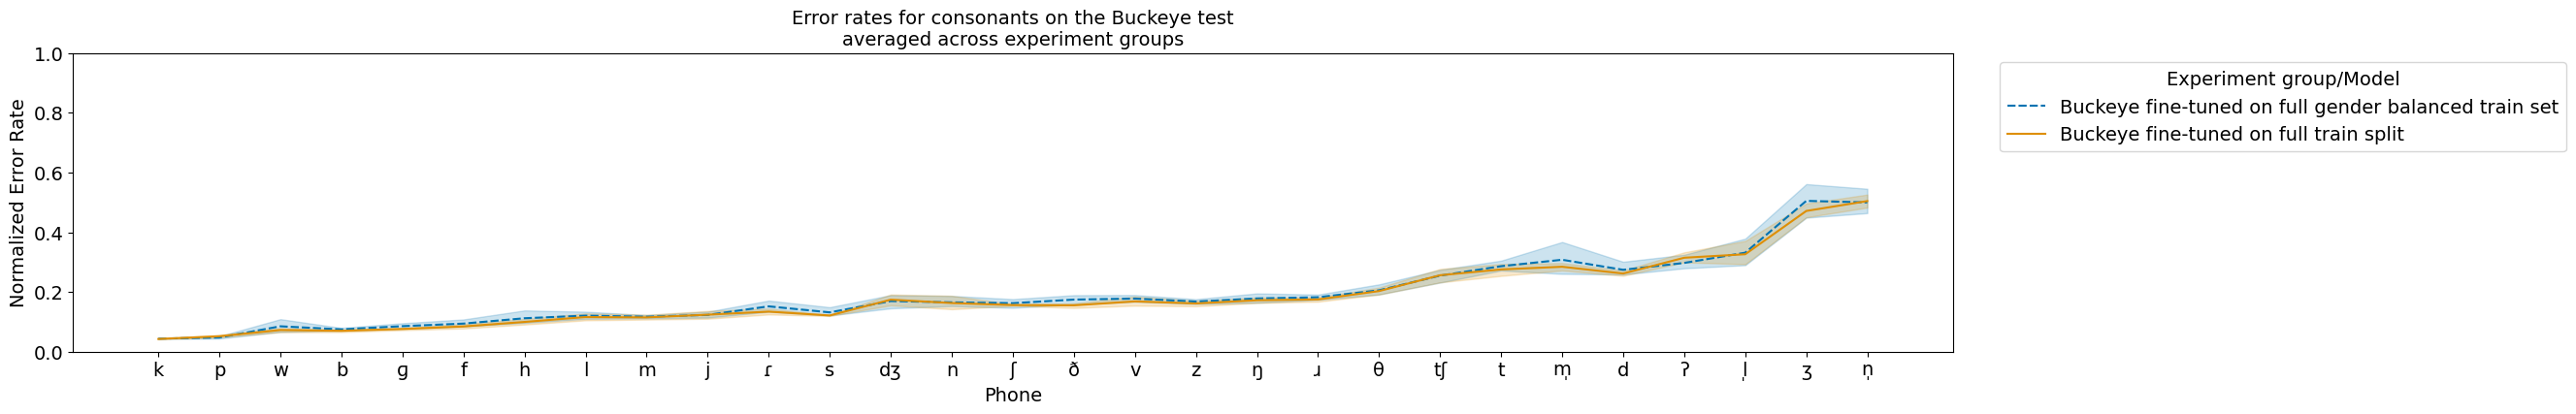

In [16]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_group", palette=PALETTE, title="Error rates for consonants on the Buckeye test\naveraged across experiment groups",)

<Axes: title={'center': 'Error rates for vowels on the Buckeye test\naveraged across experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

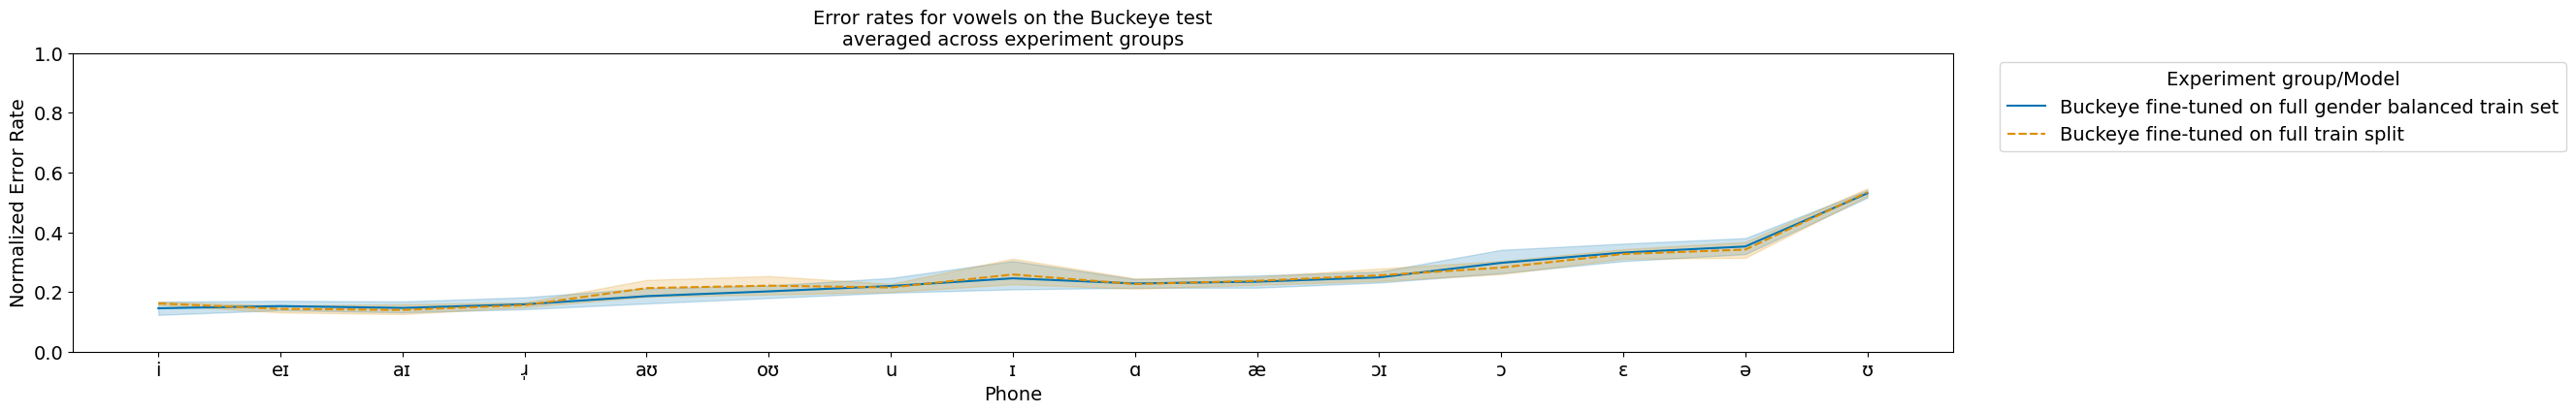

In [17]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_group", palette=PALETTE, title="Error rates for vowels on the Buckeye test\naveraged across experiment groups",)

# Confusion matrices
Get the confusion matrix for each model's errors. Display confusion matrix separated by consonants and vowels separately for a few select models. 

In [18]:
# Gets the confusion matrix for each model
conf_matrices = {}
for mn in model_names:
    print("Model name:", mn)
    conf_matrices[mn] = MODEL_EVALUATOR.get_token_confusion_matrix(mn)


Model name: train_duration_20000_samples_1
Model name: train_duration_20000_samples_2
Model name: train_duration_20000_samples_3
Model name: train_duration_20000_samples_4
Model name: train_duration_20000_samples_5
Model name: full_dataset_train_1
Model name: full_dataset_train_2
Model name: full_dataset_train_3
Model name: full_dataset_train_4
Model name: full_dataset_train_5
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified


<Figure size 640x480 with 0 Axes>

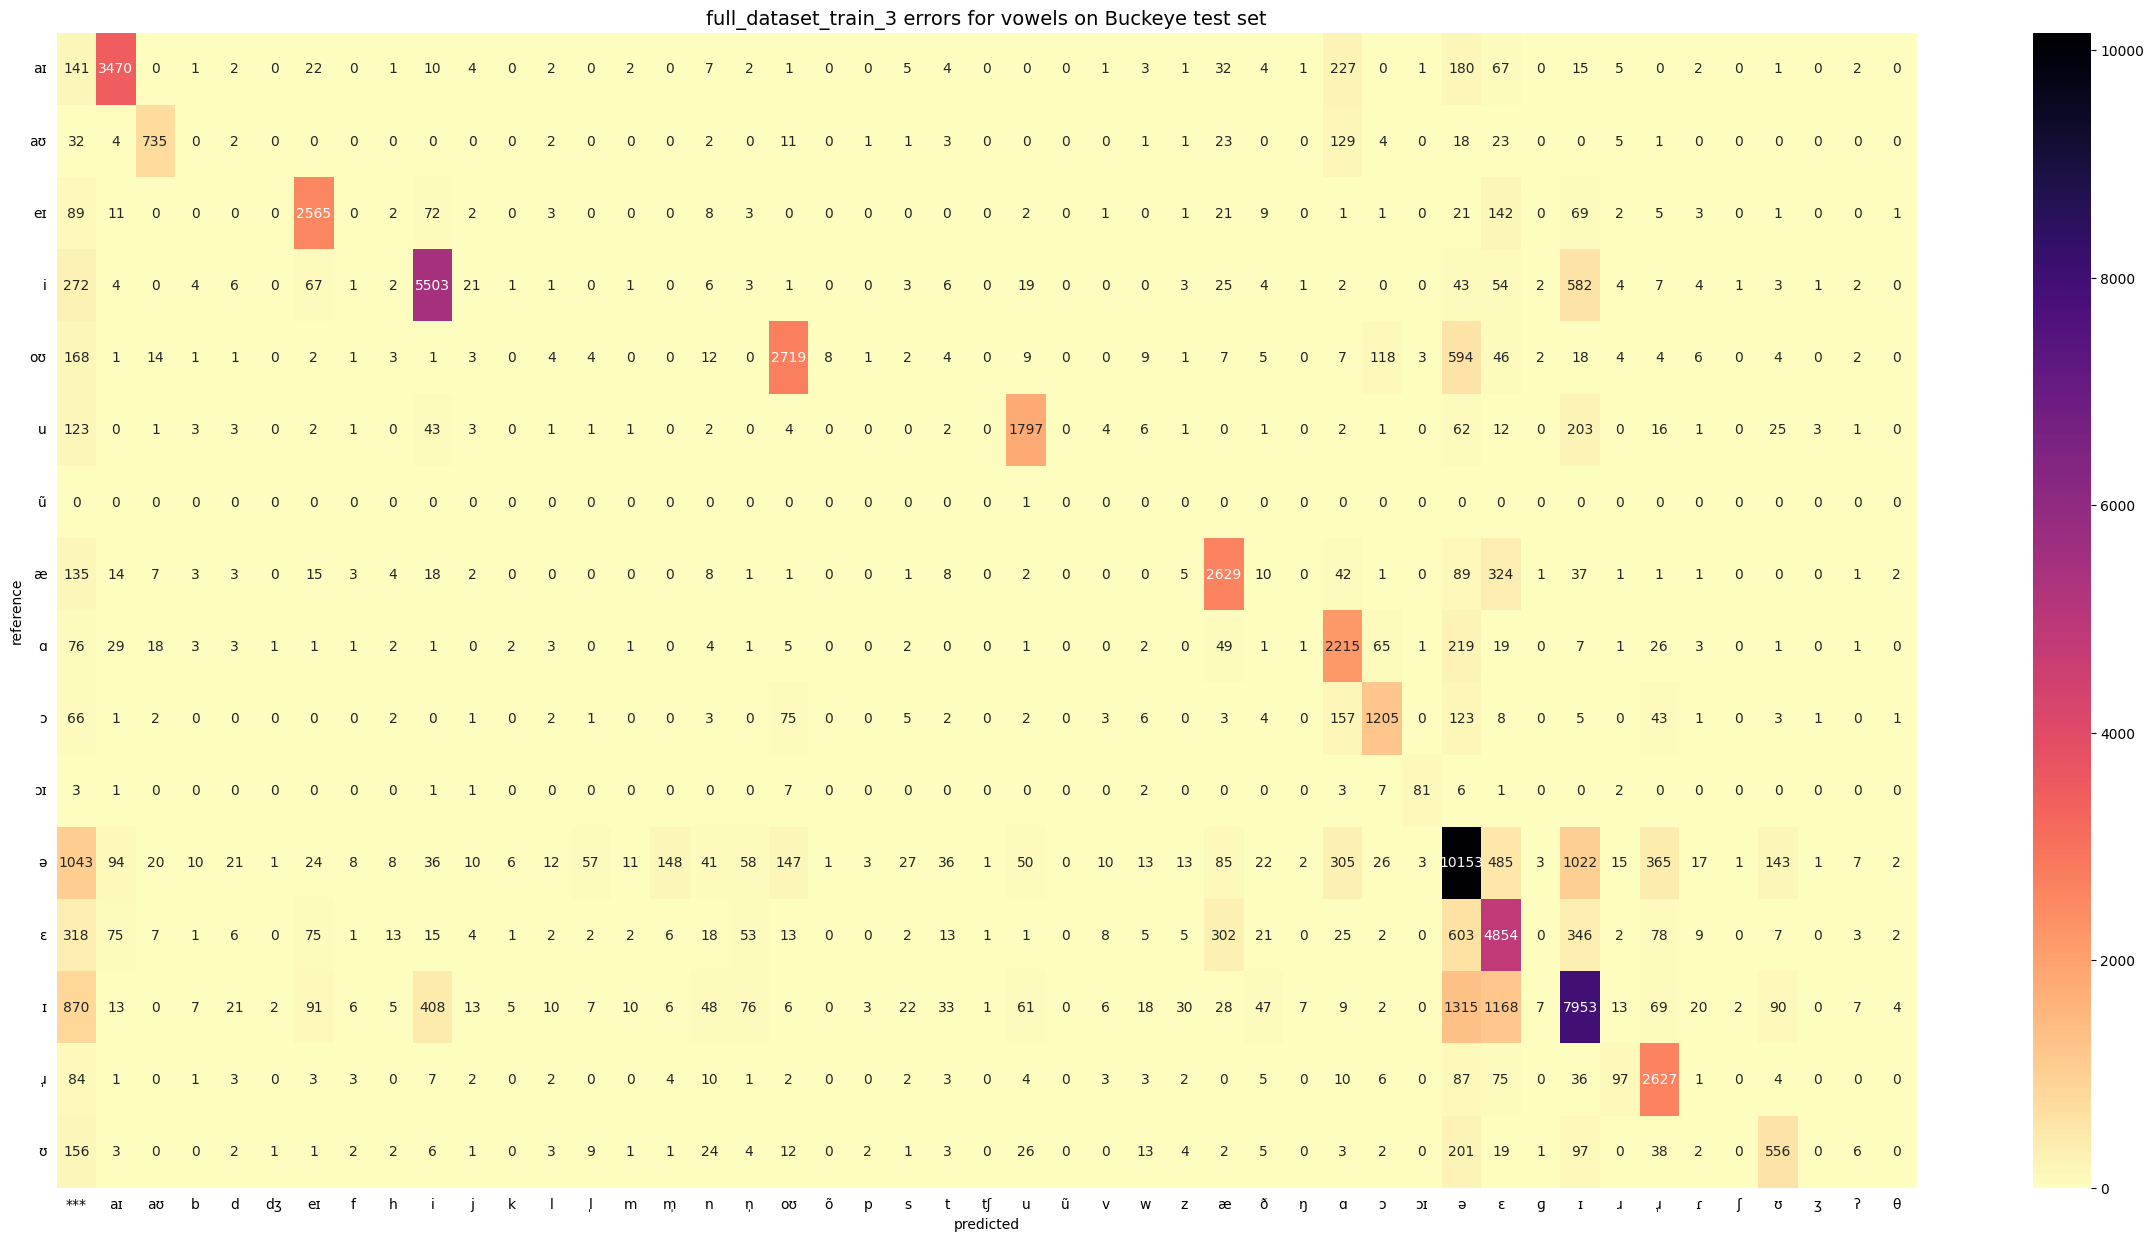

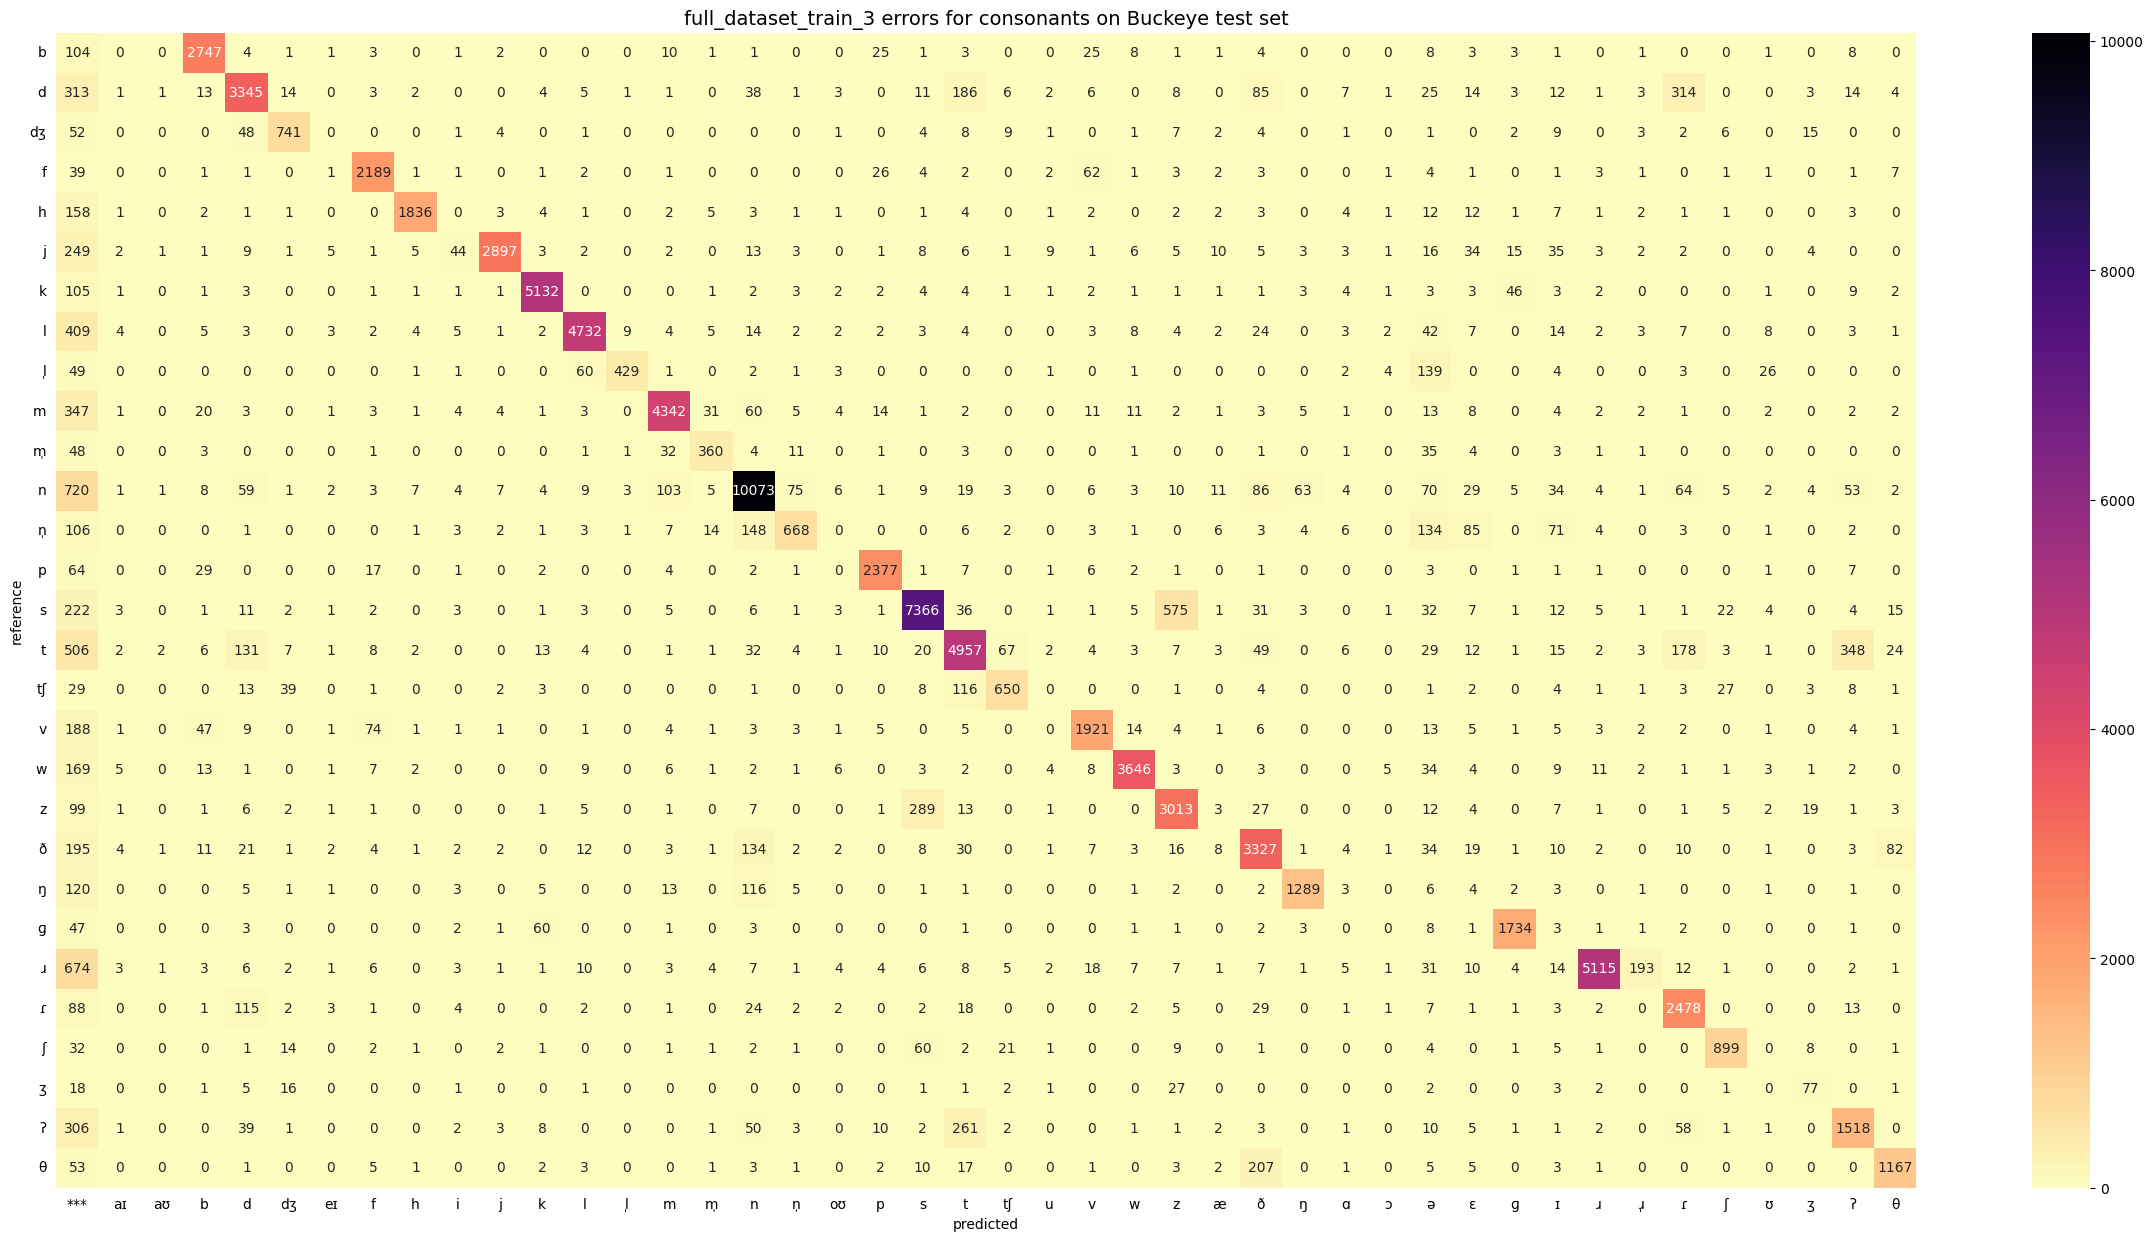

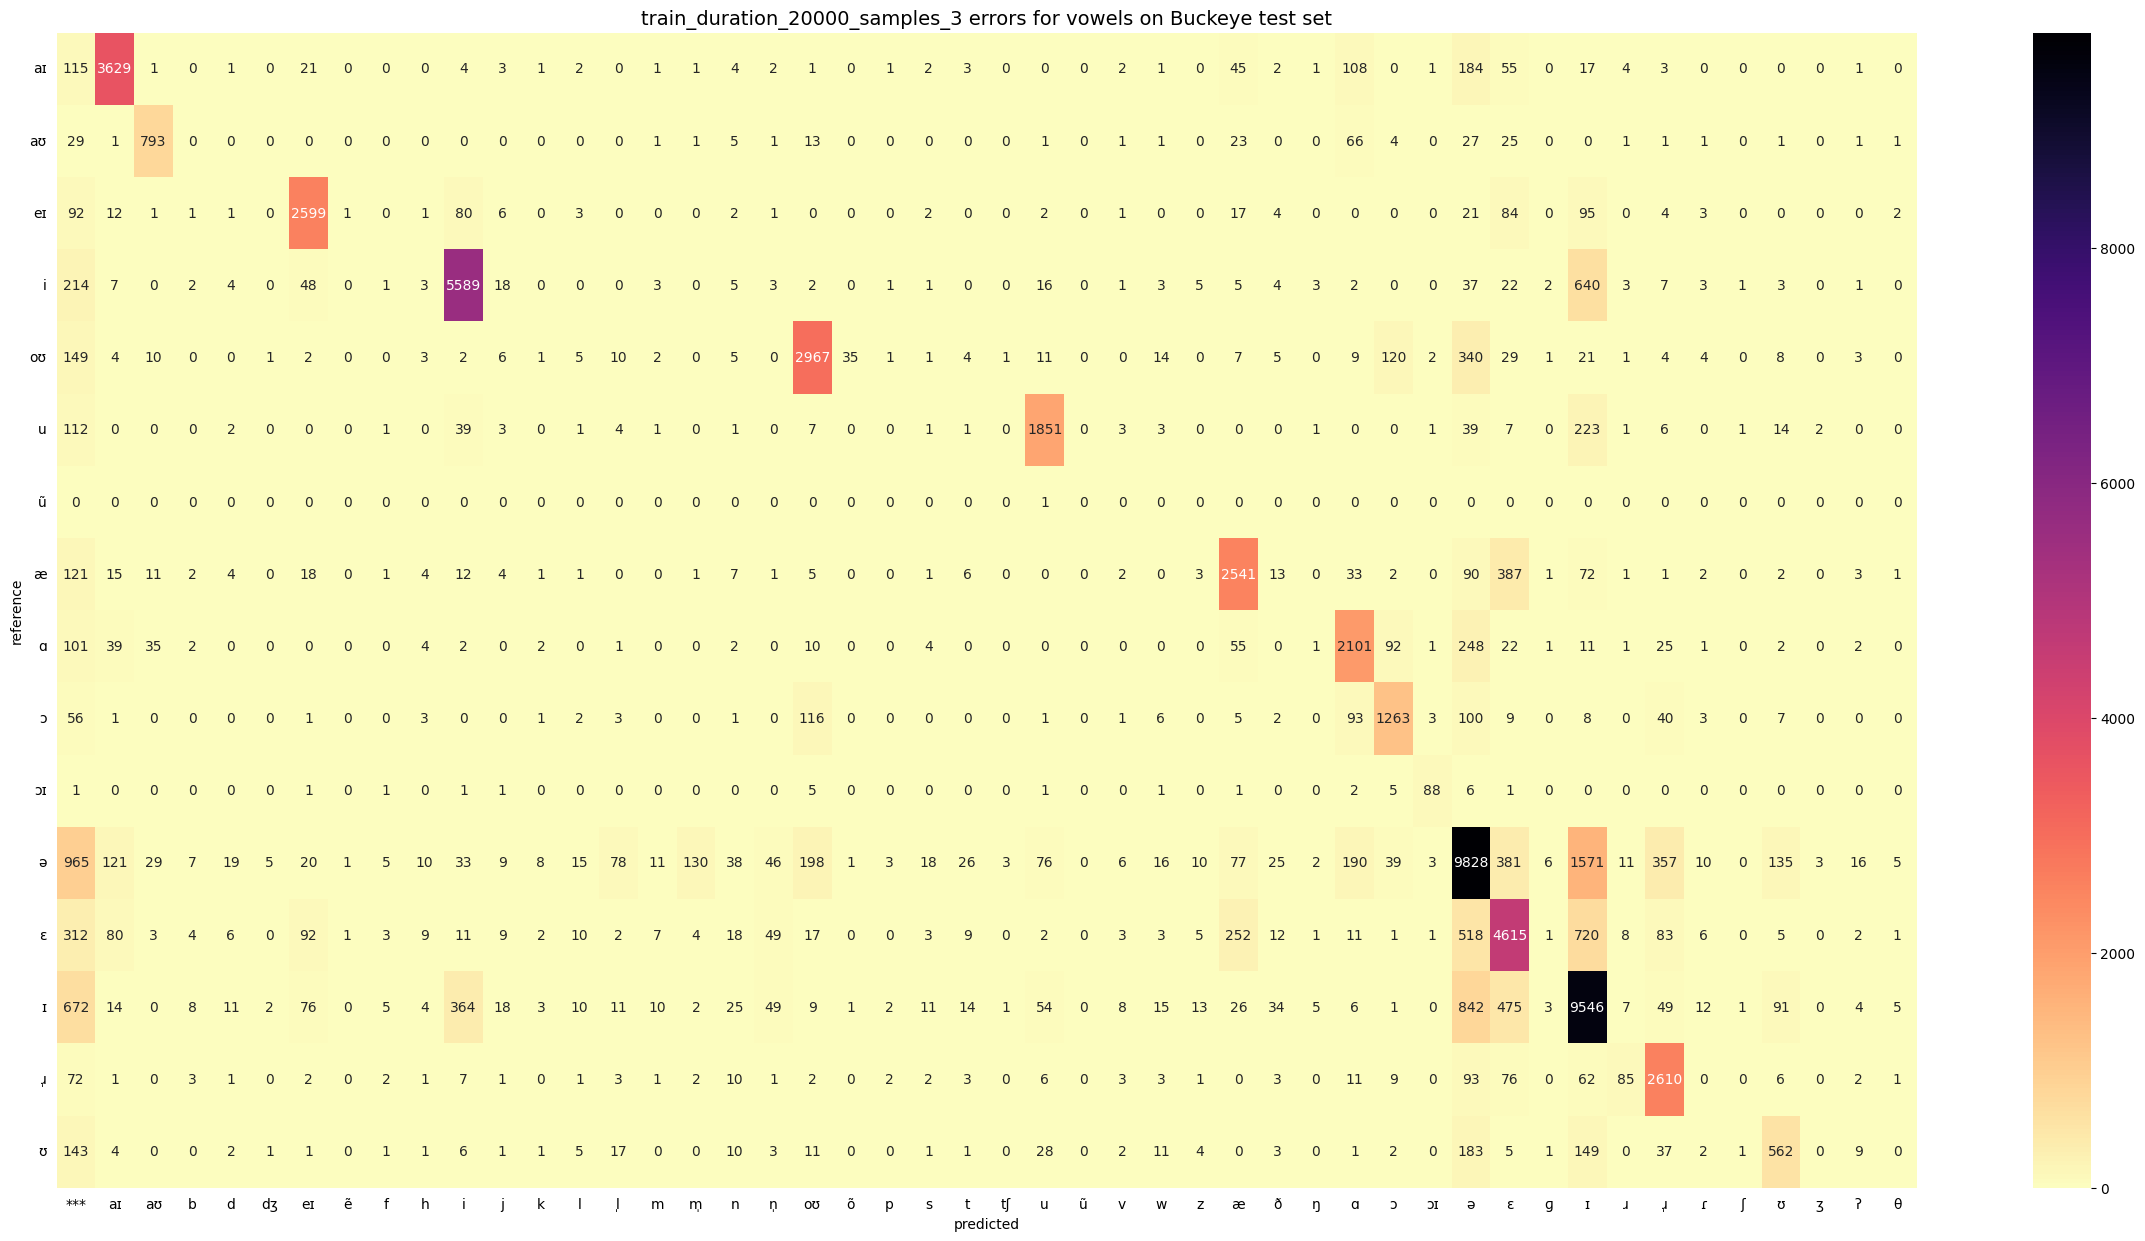

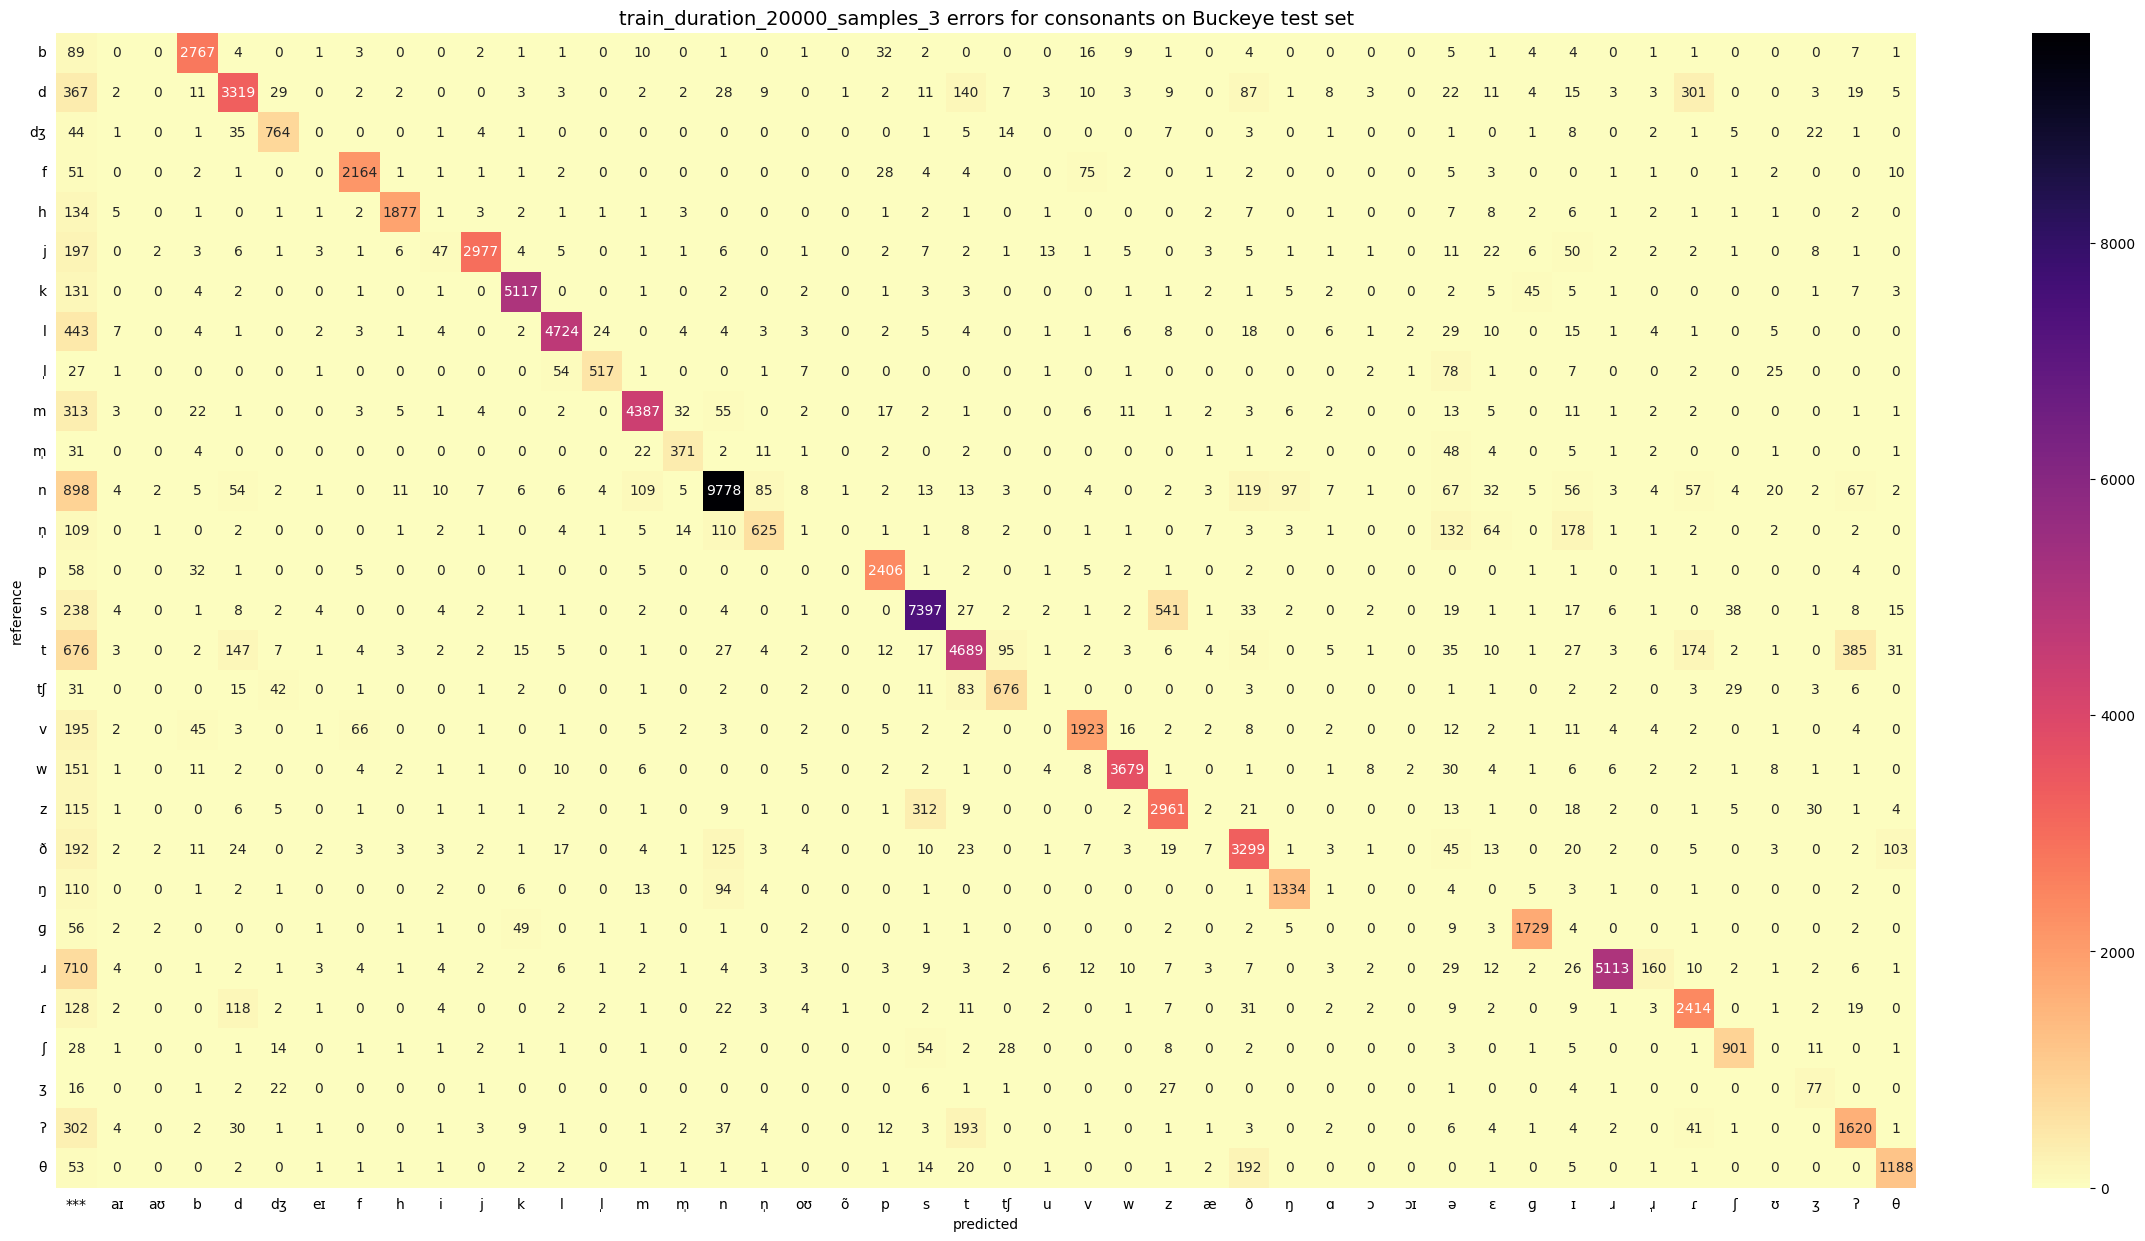

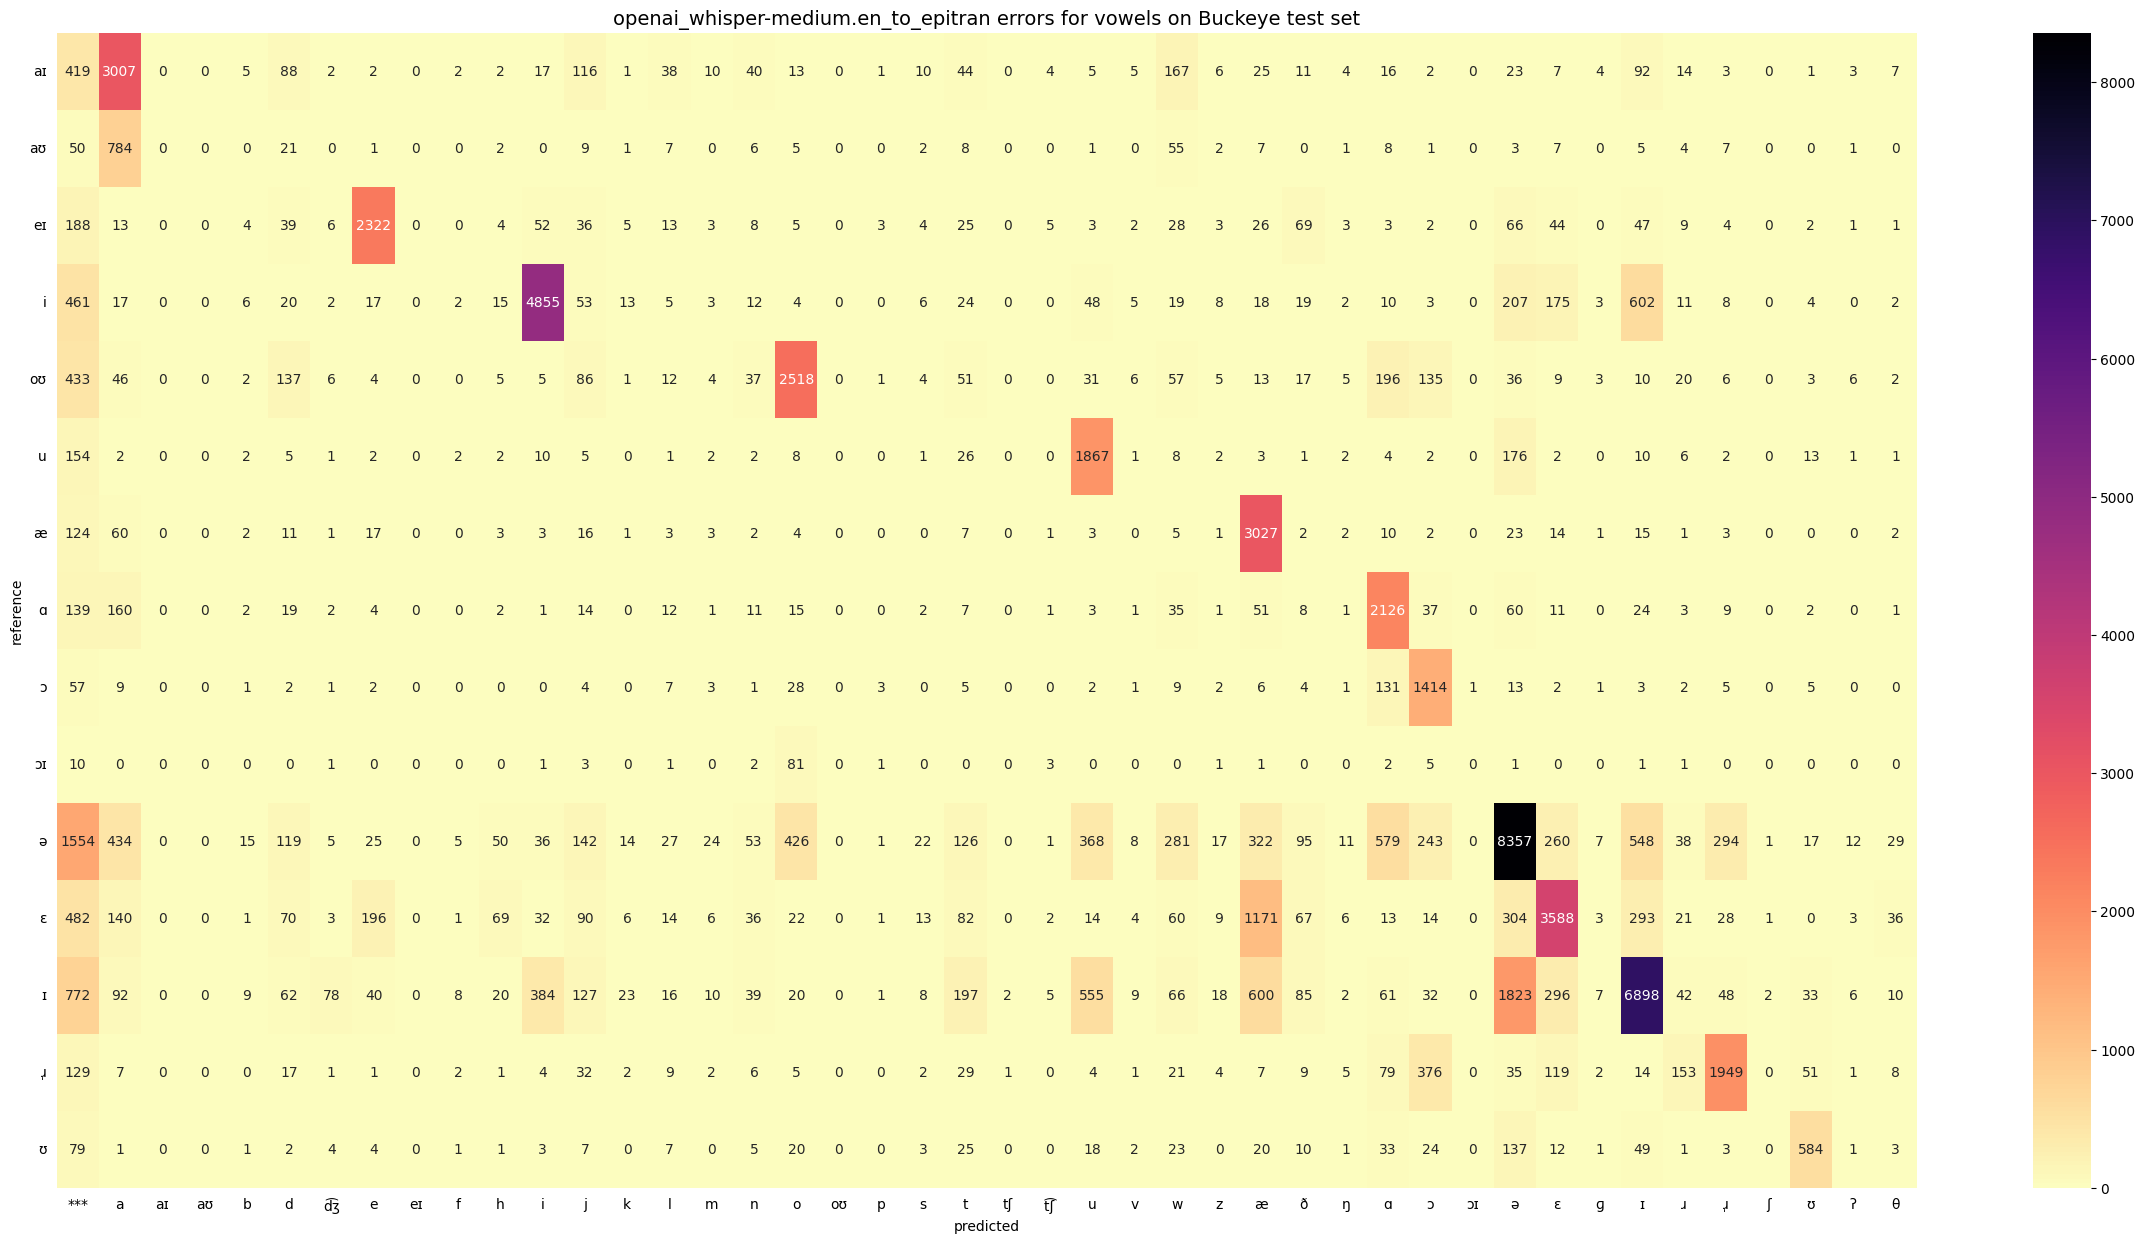

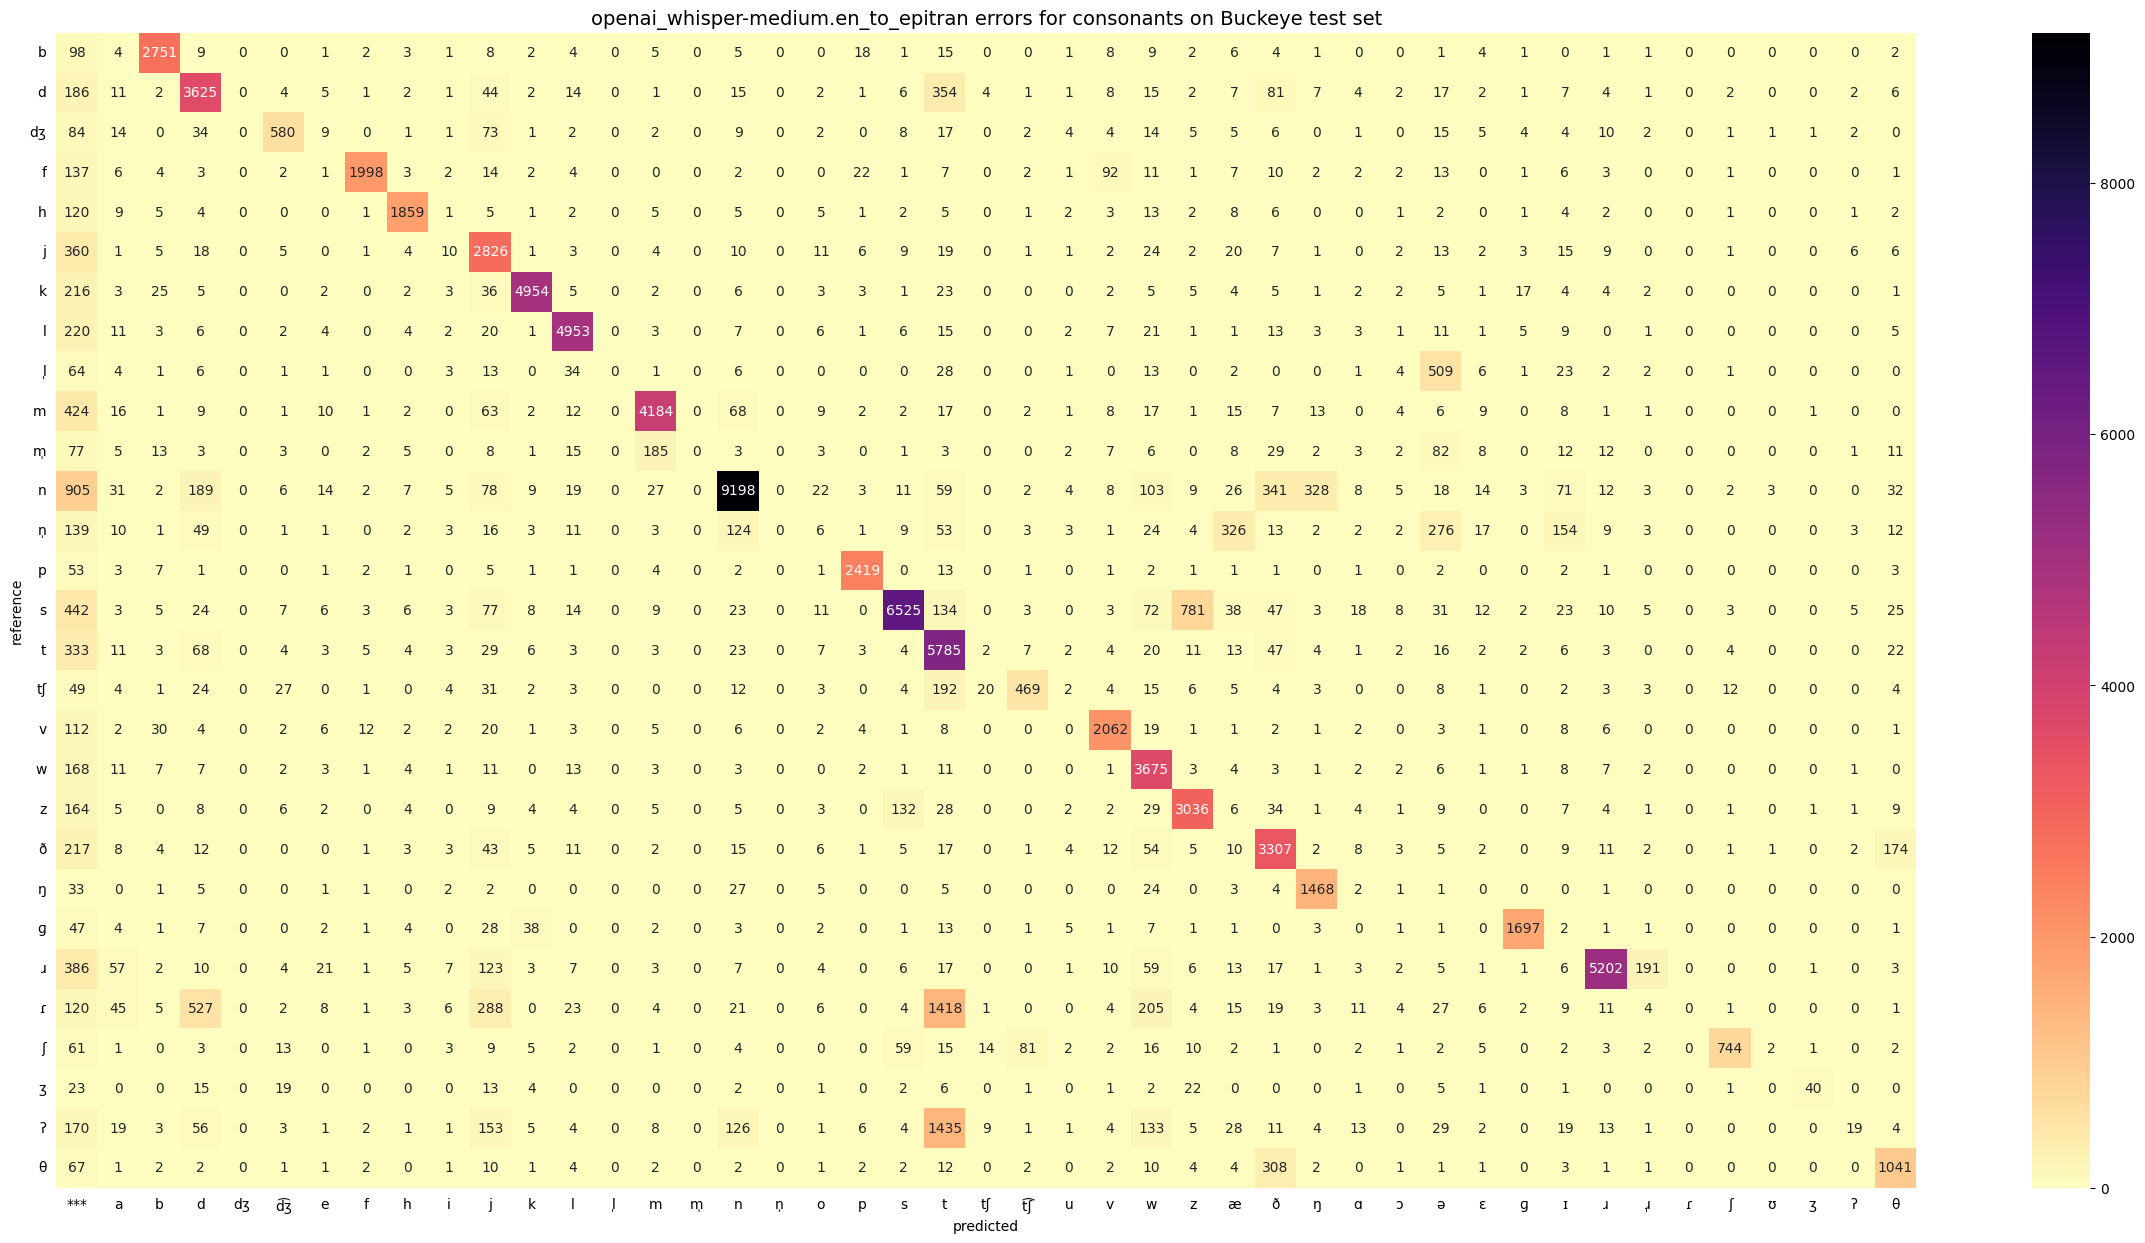

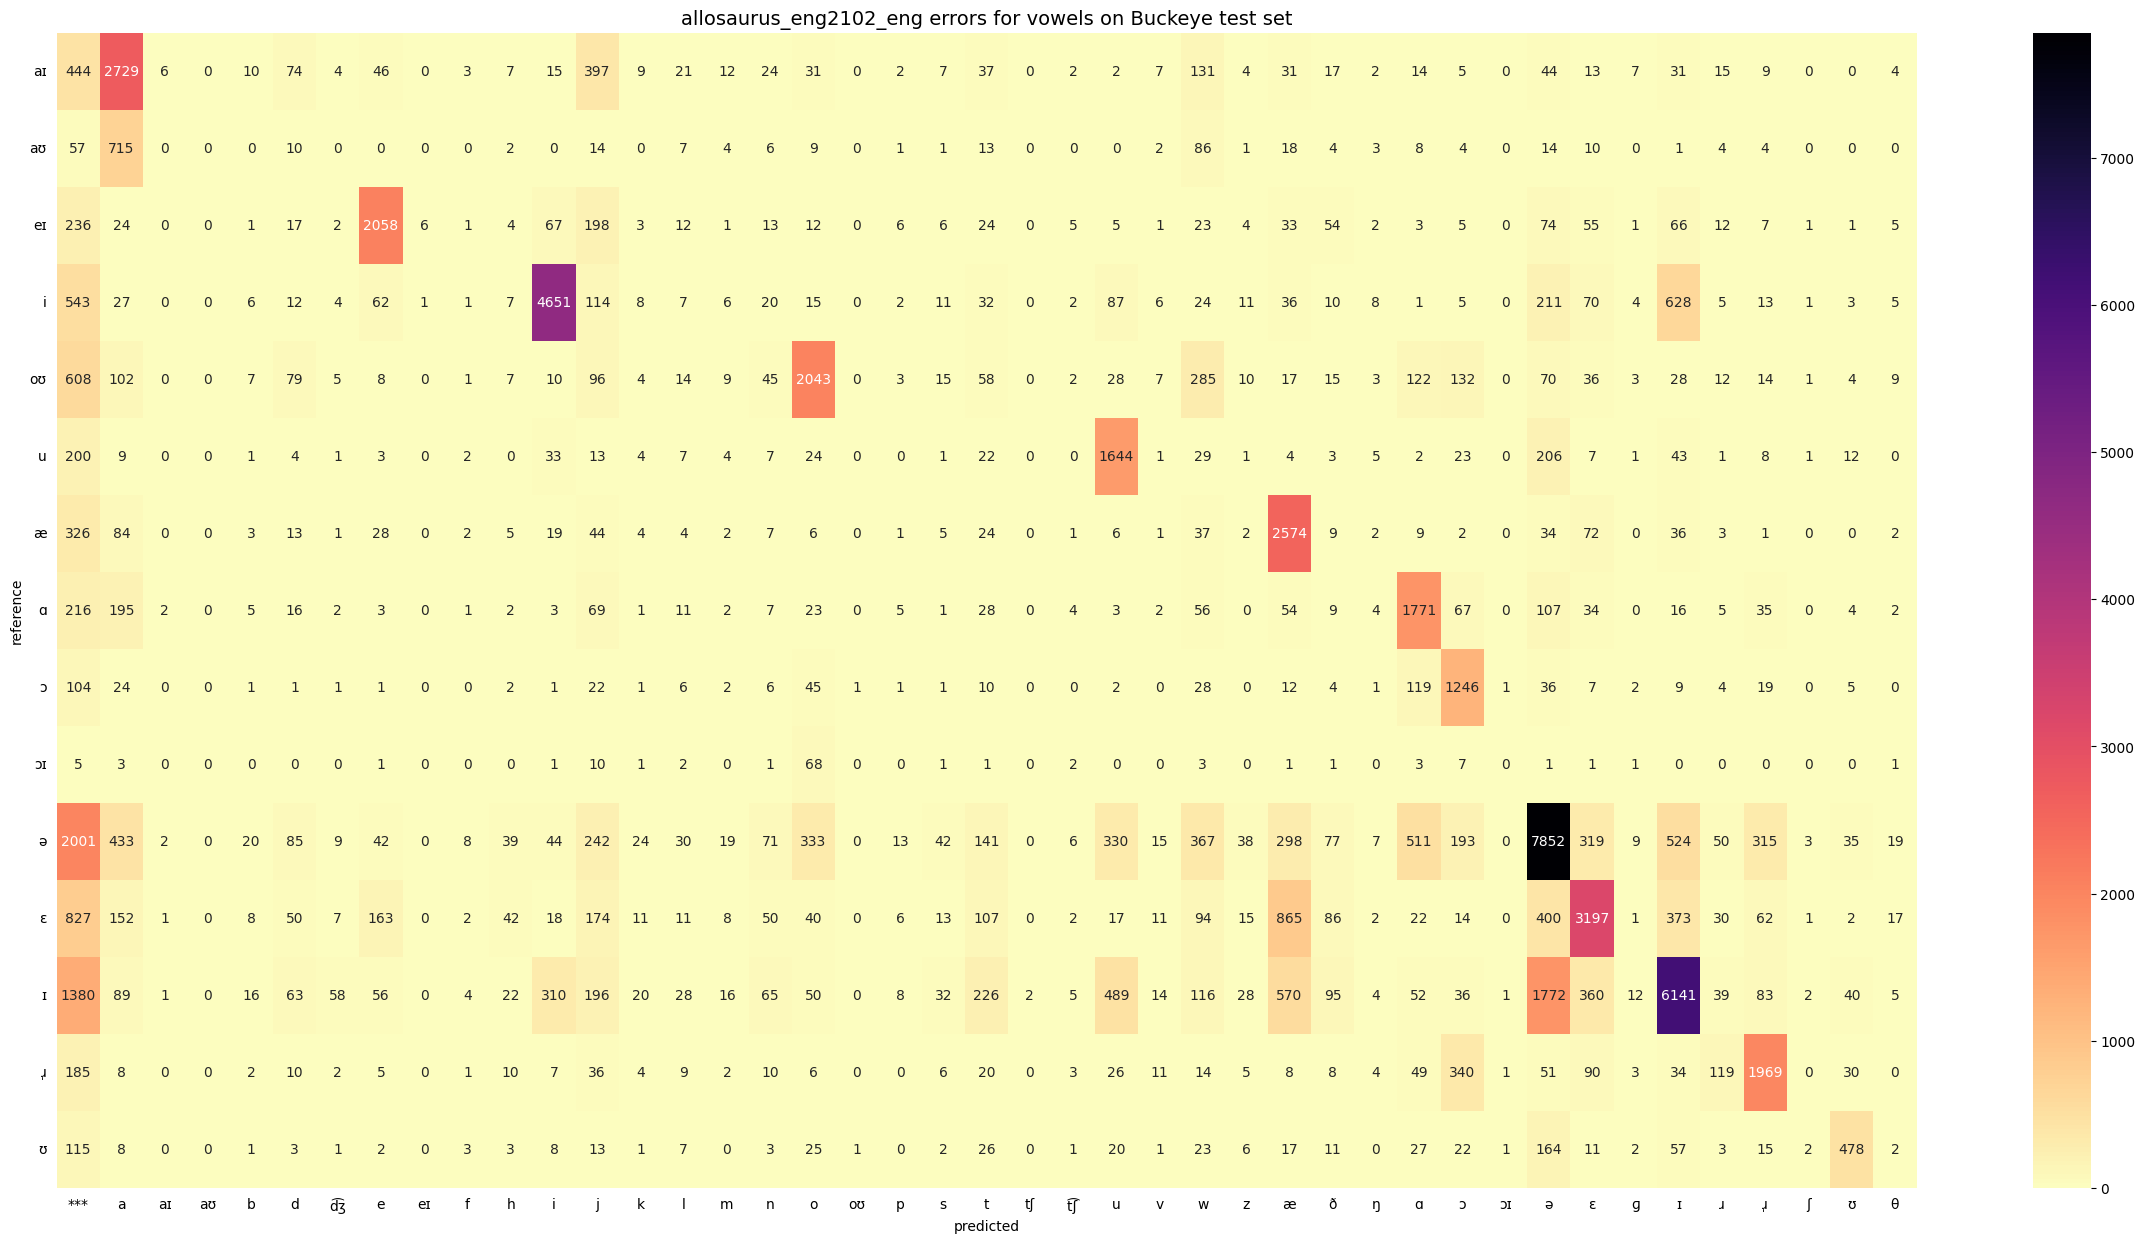

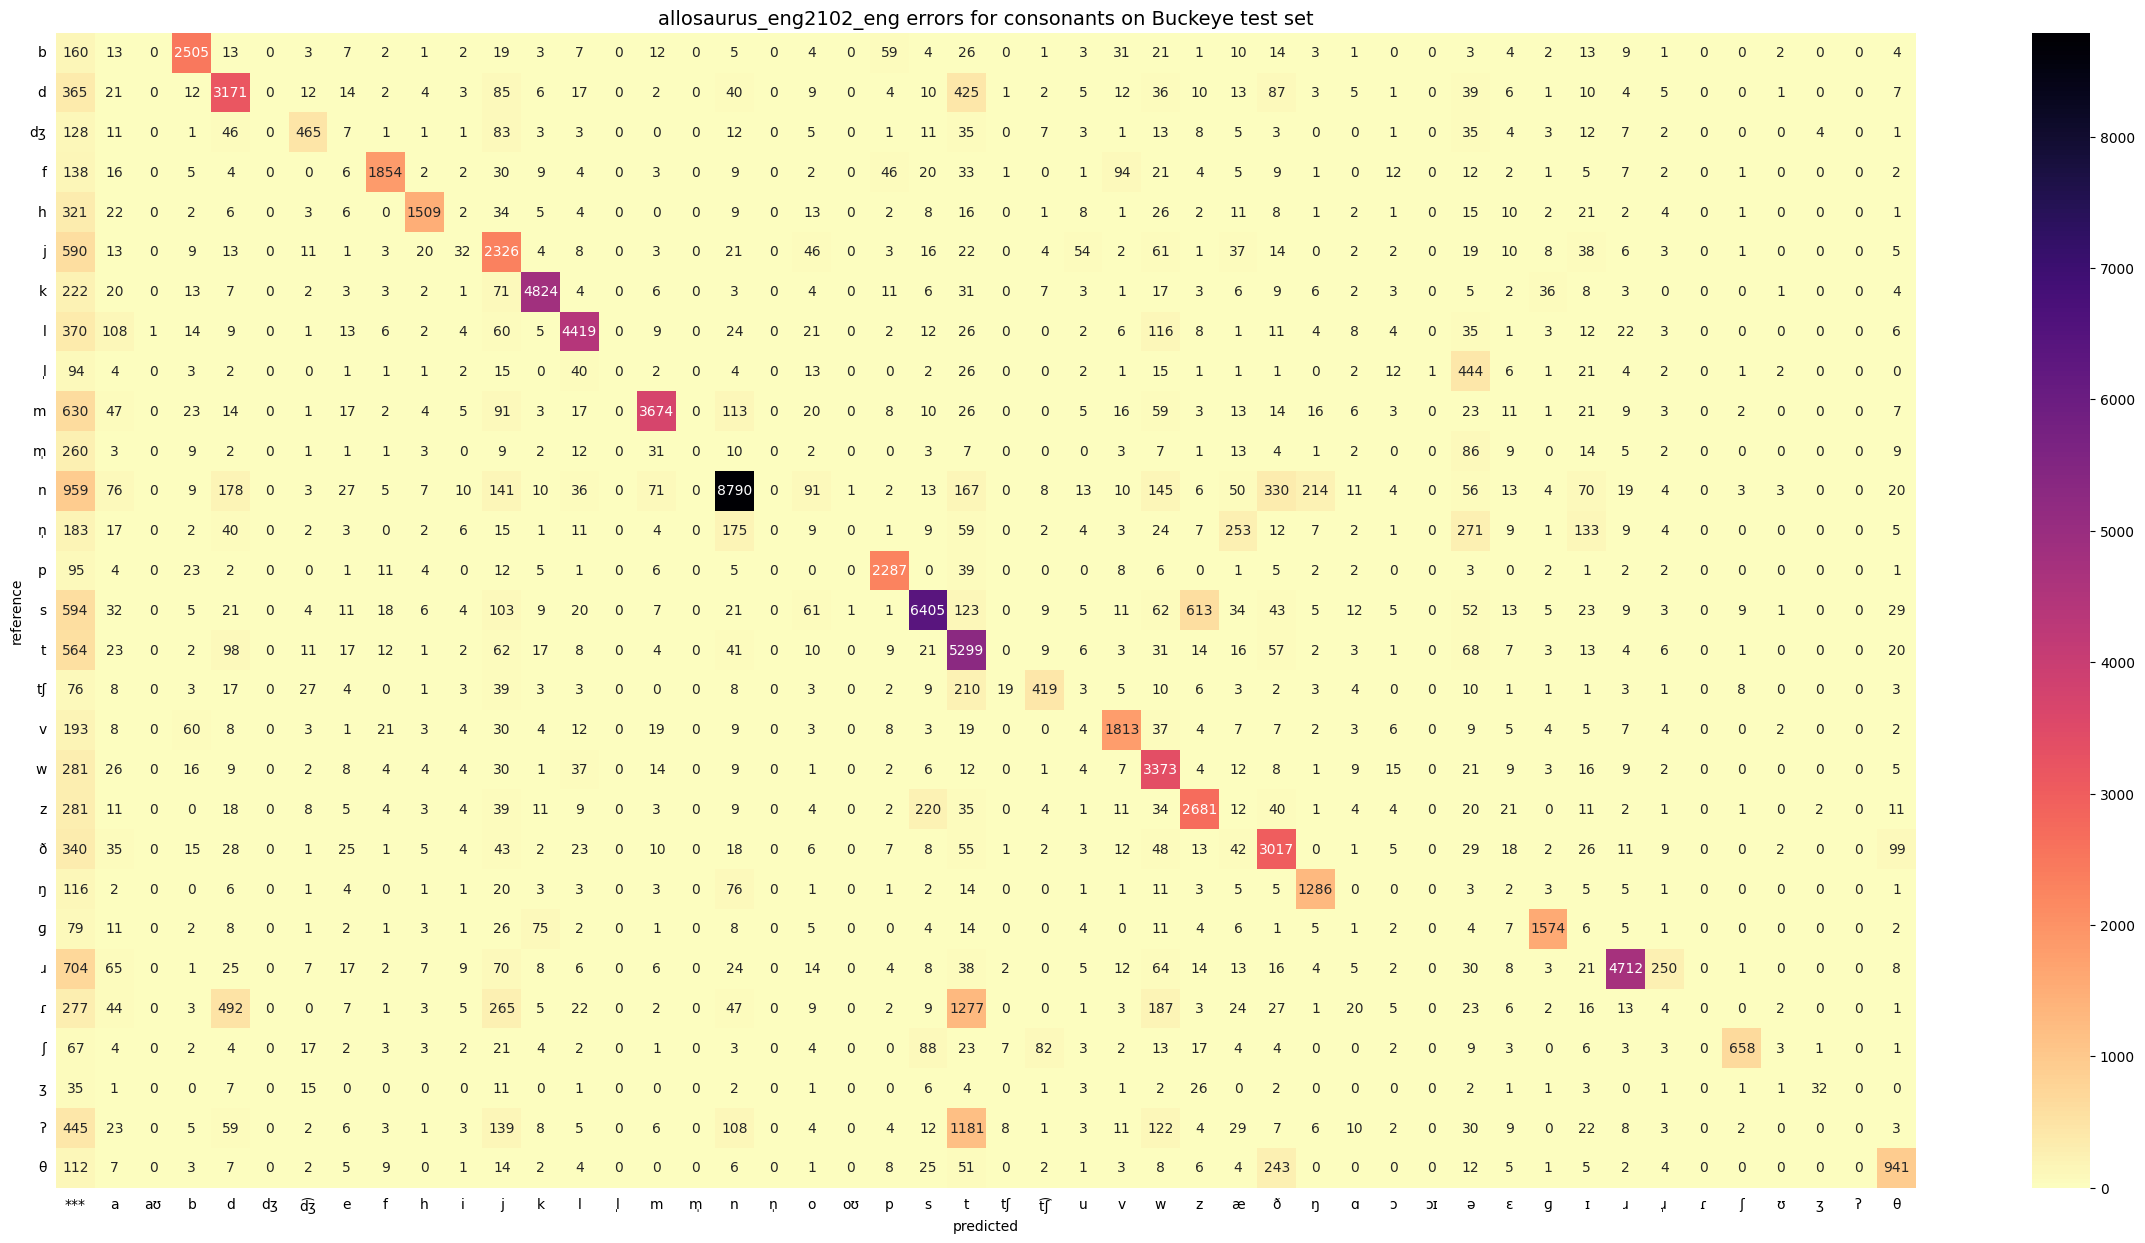

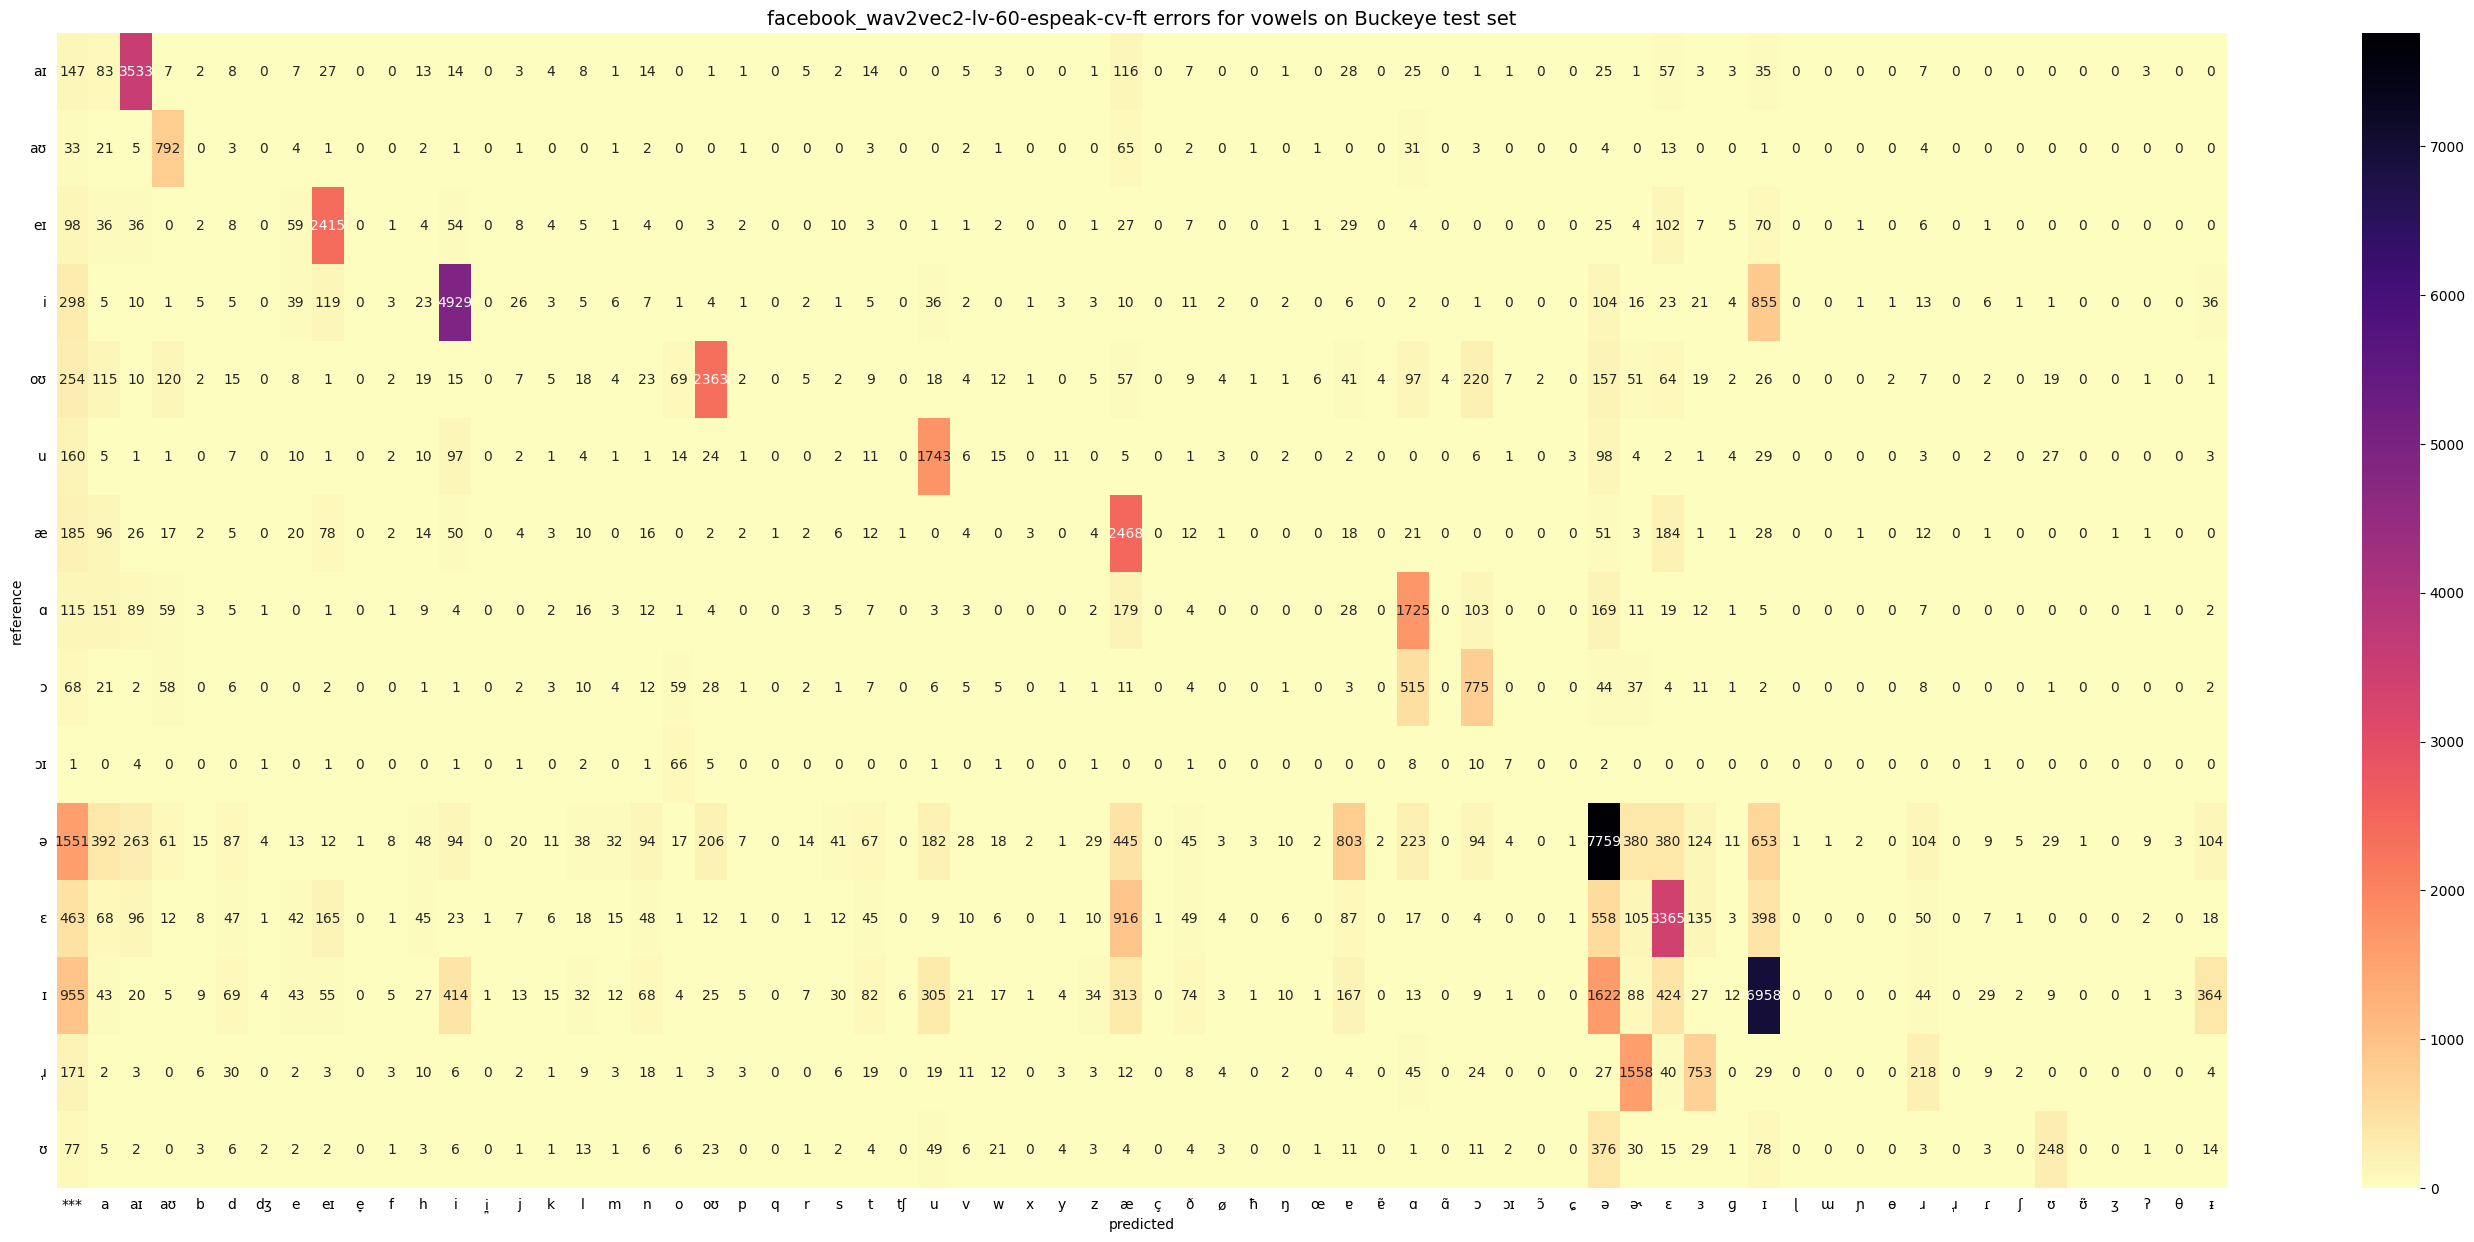

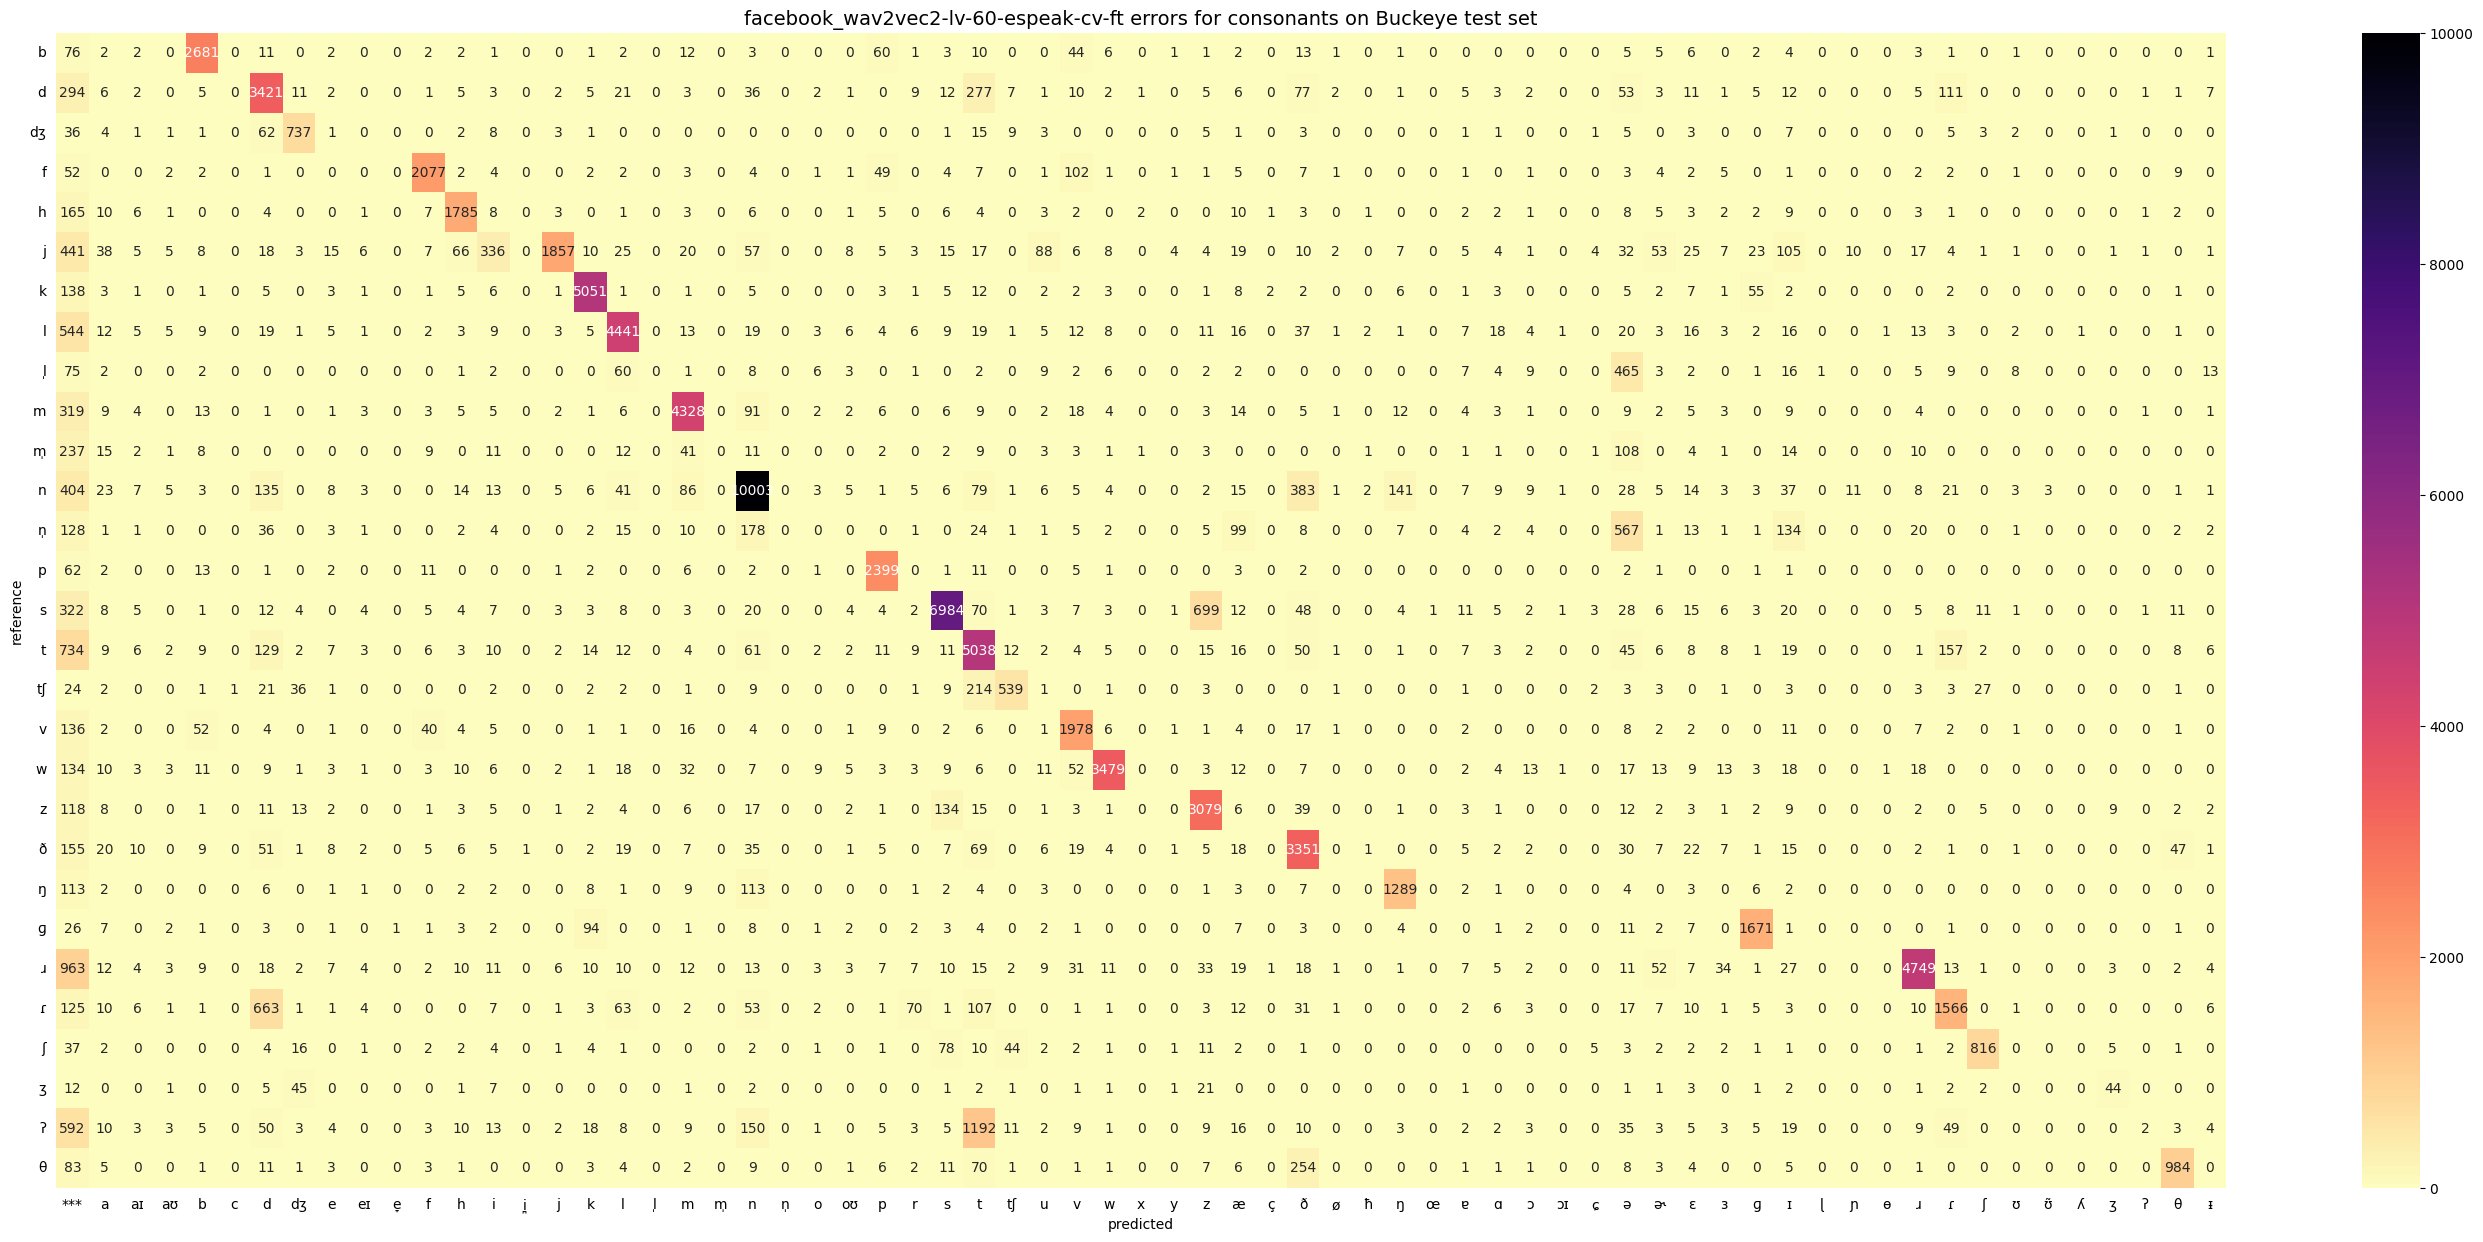

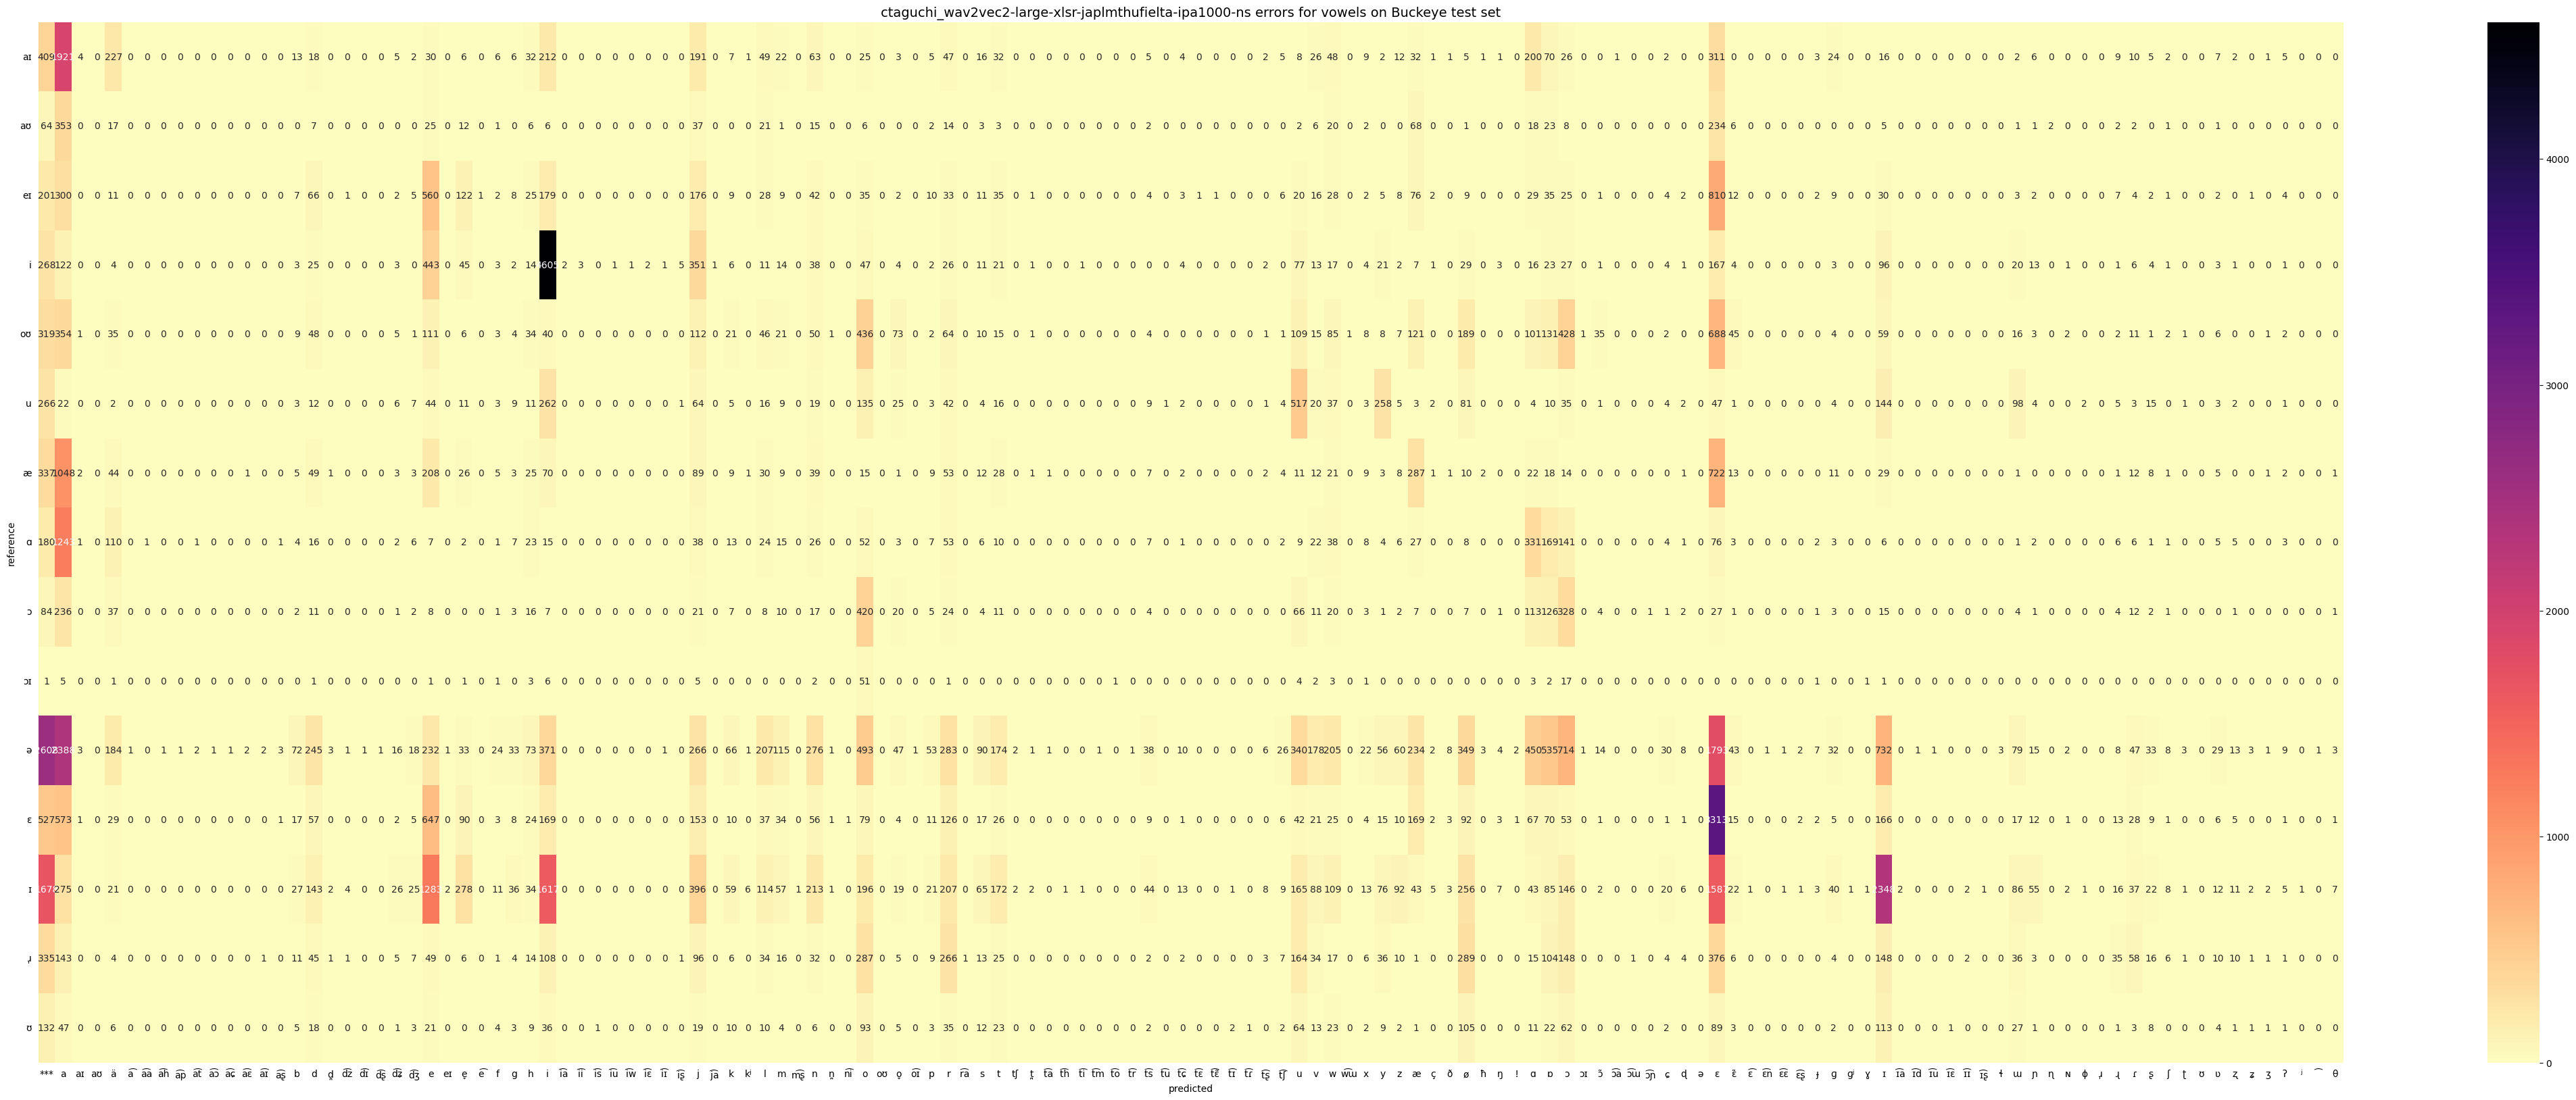

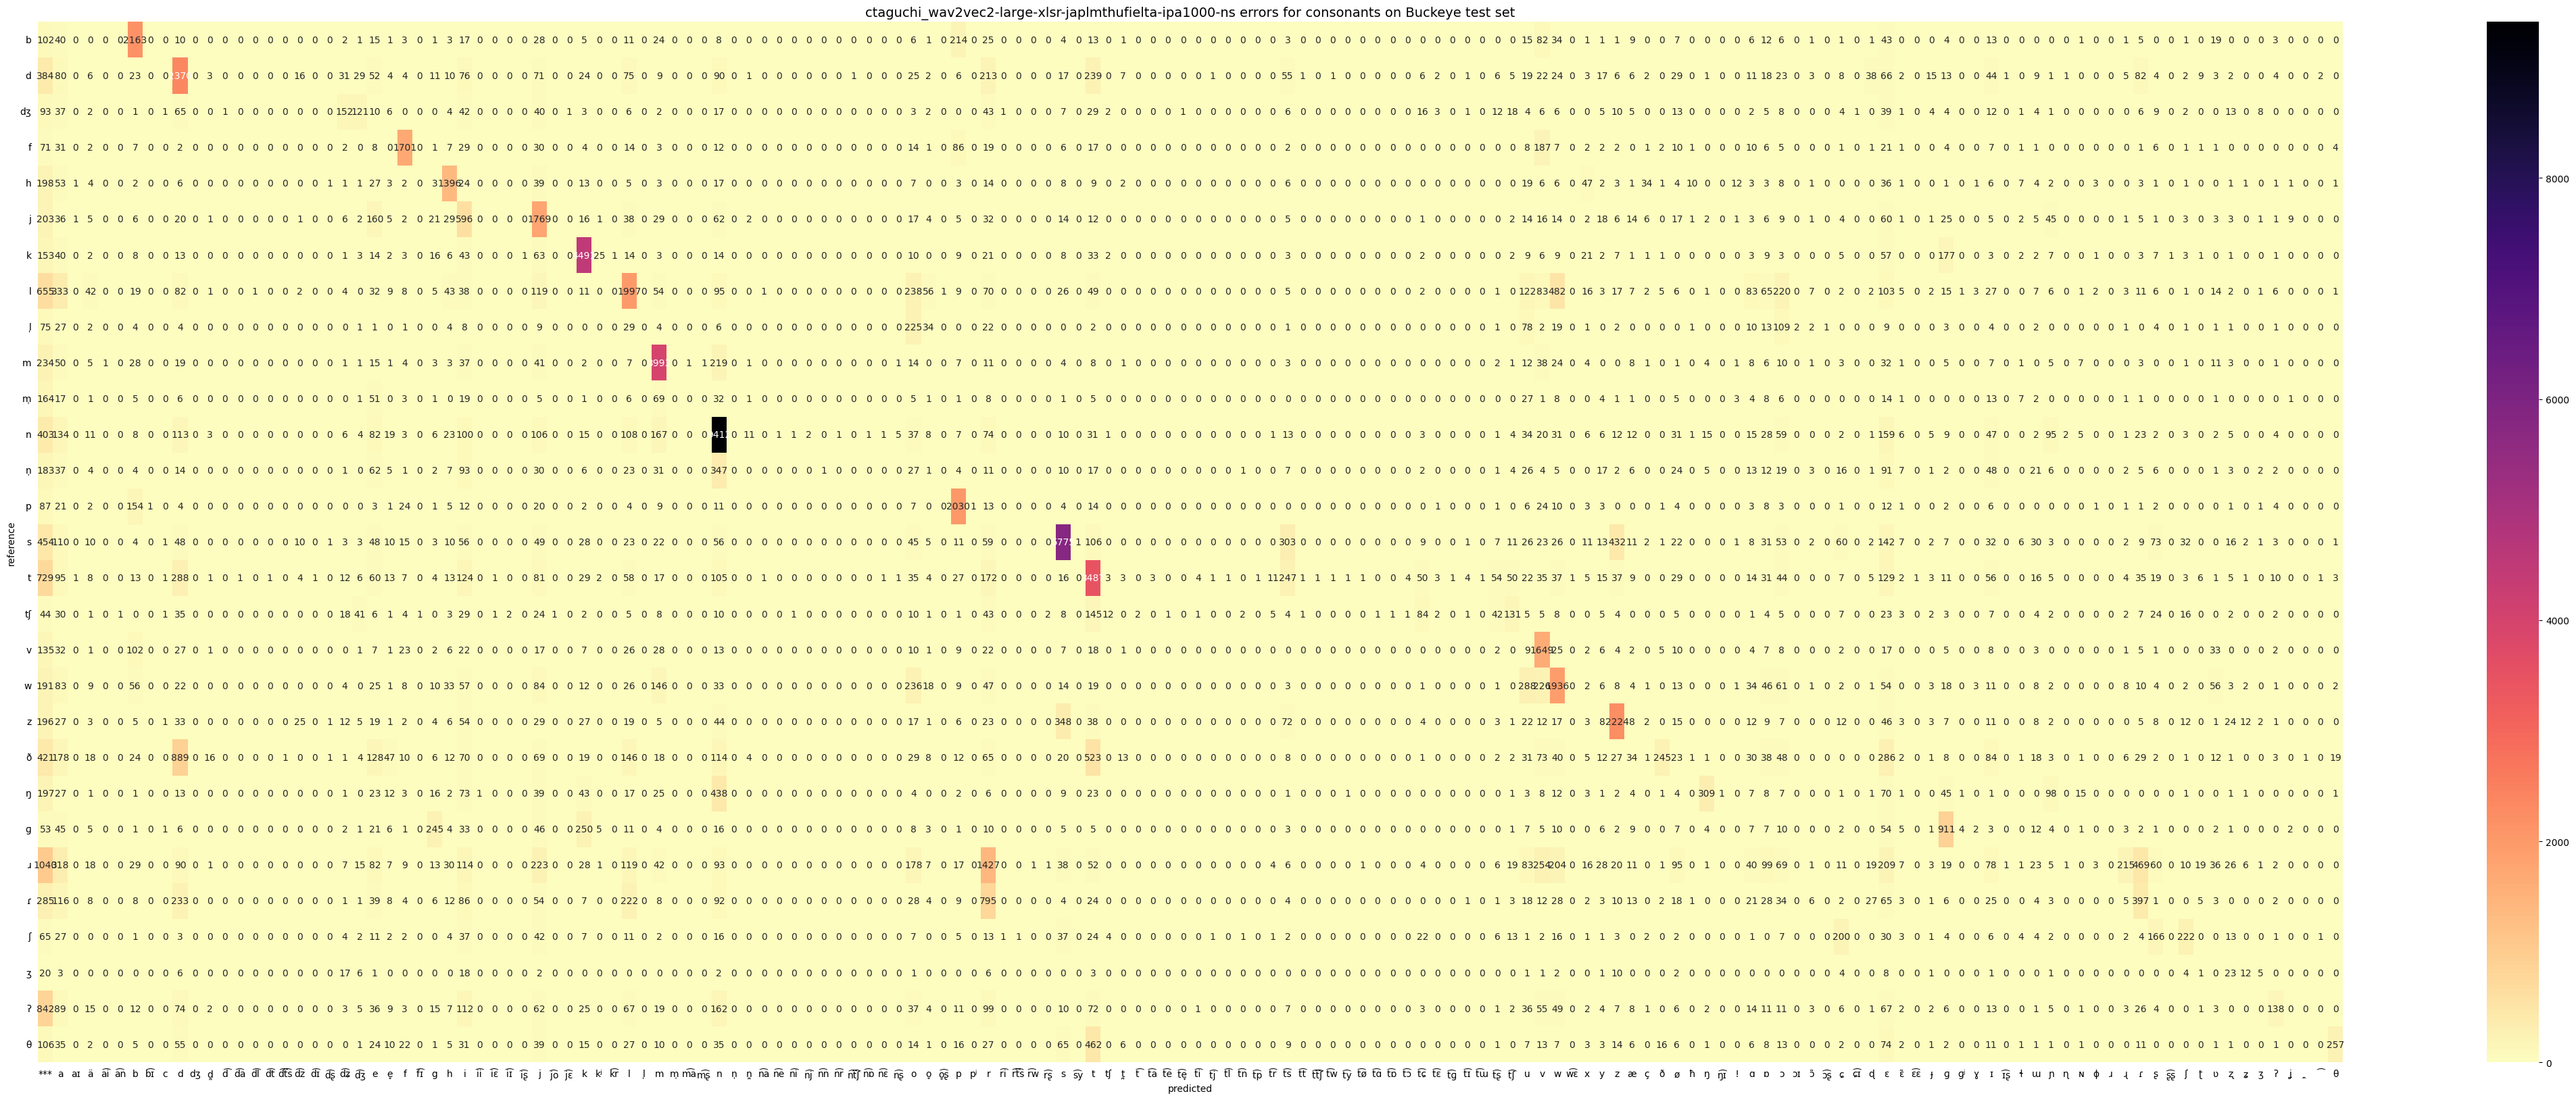

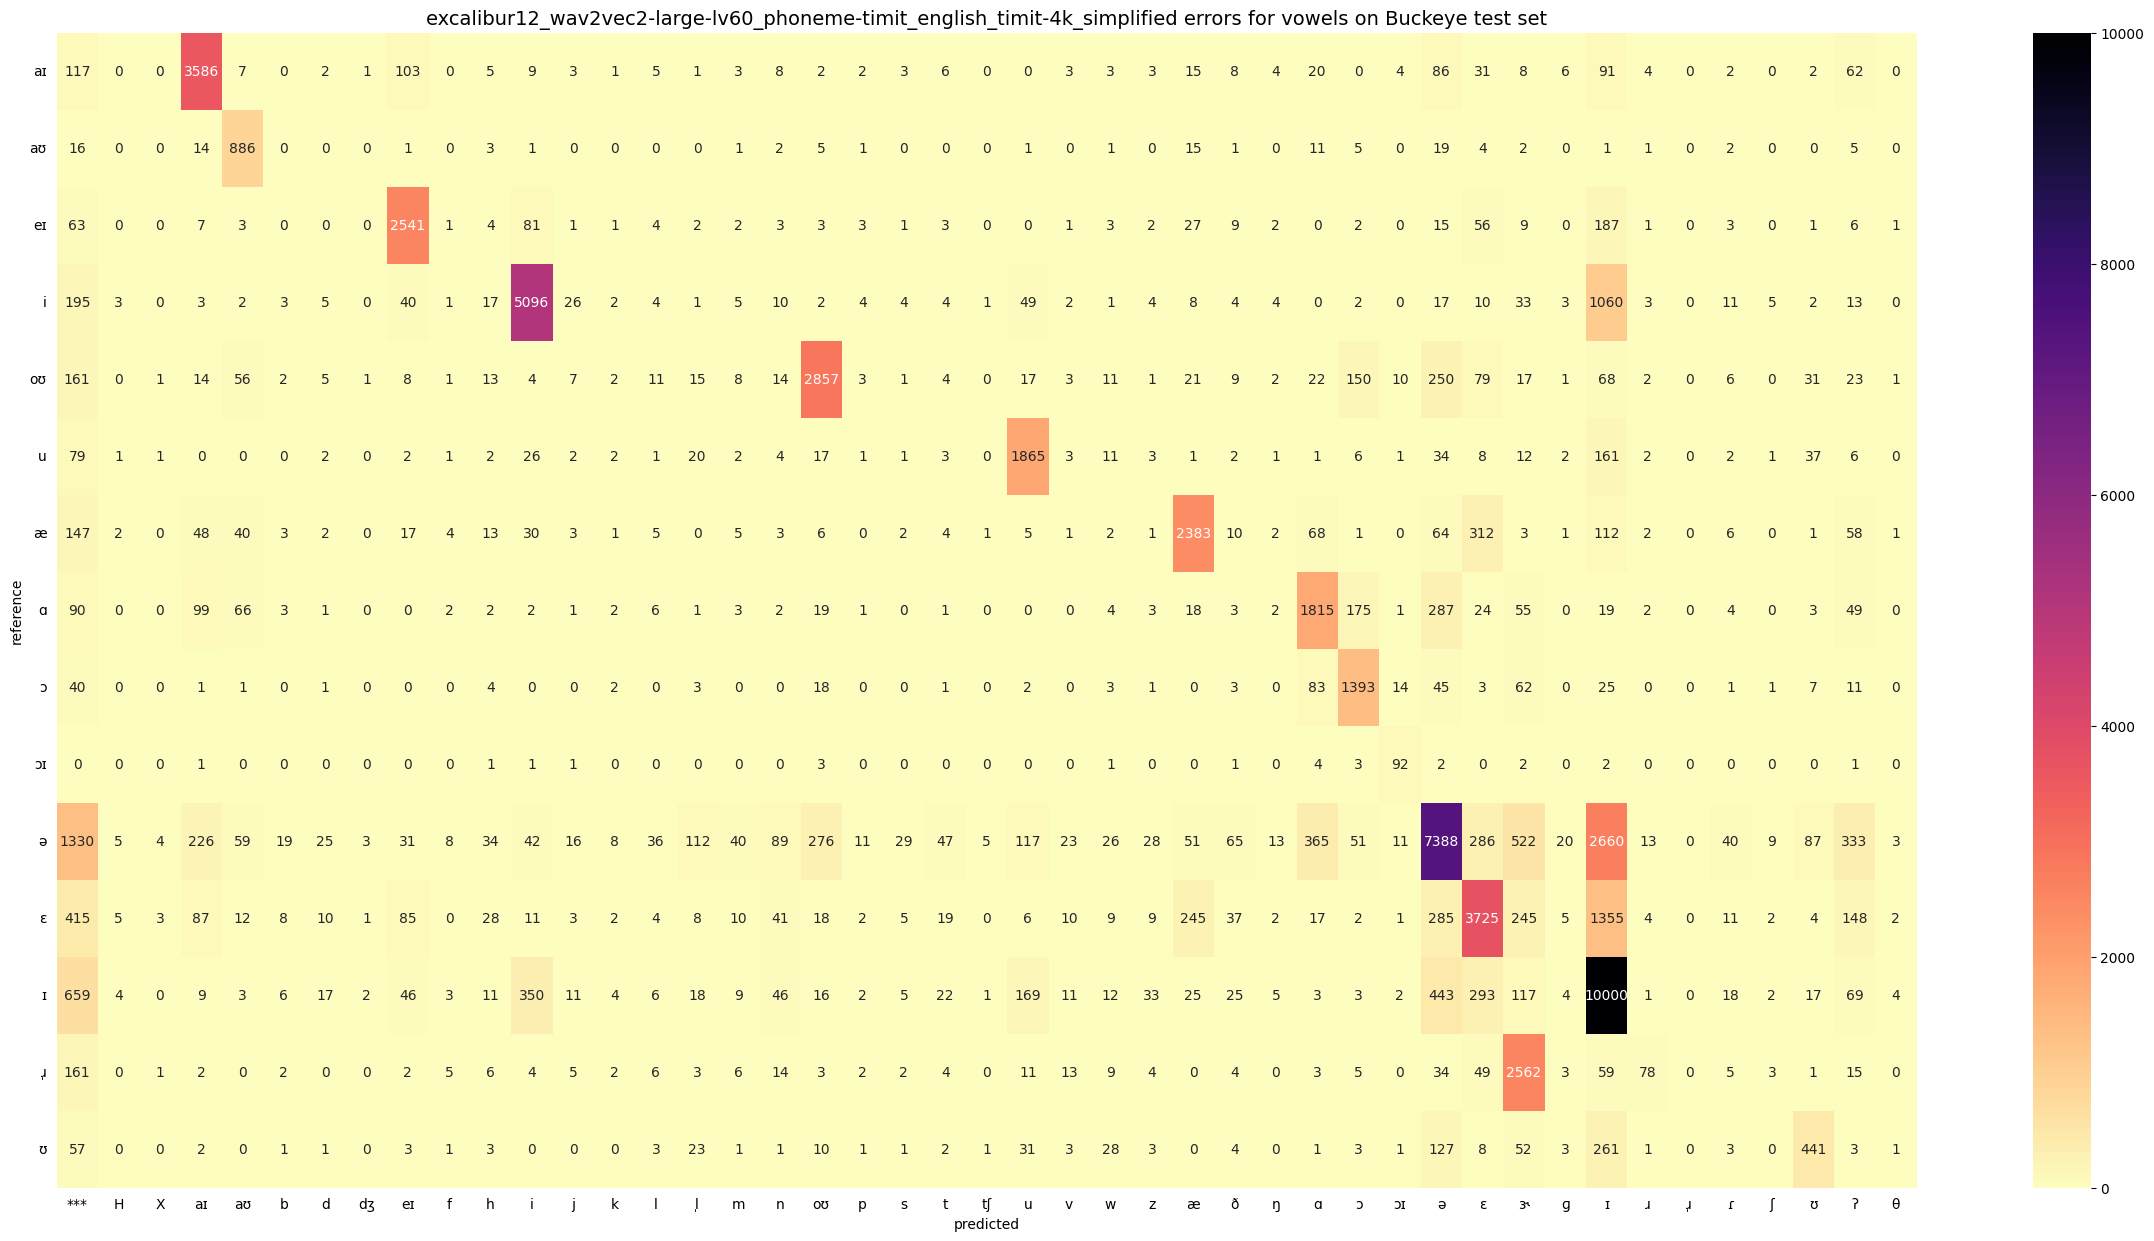

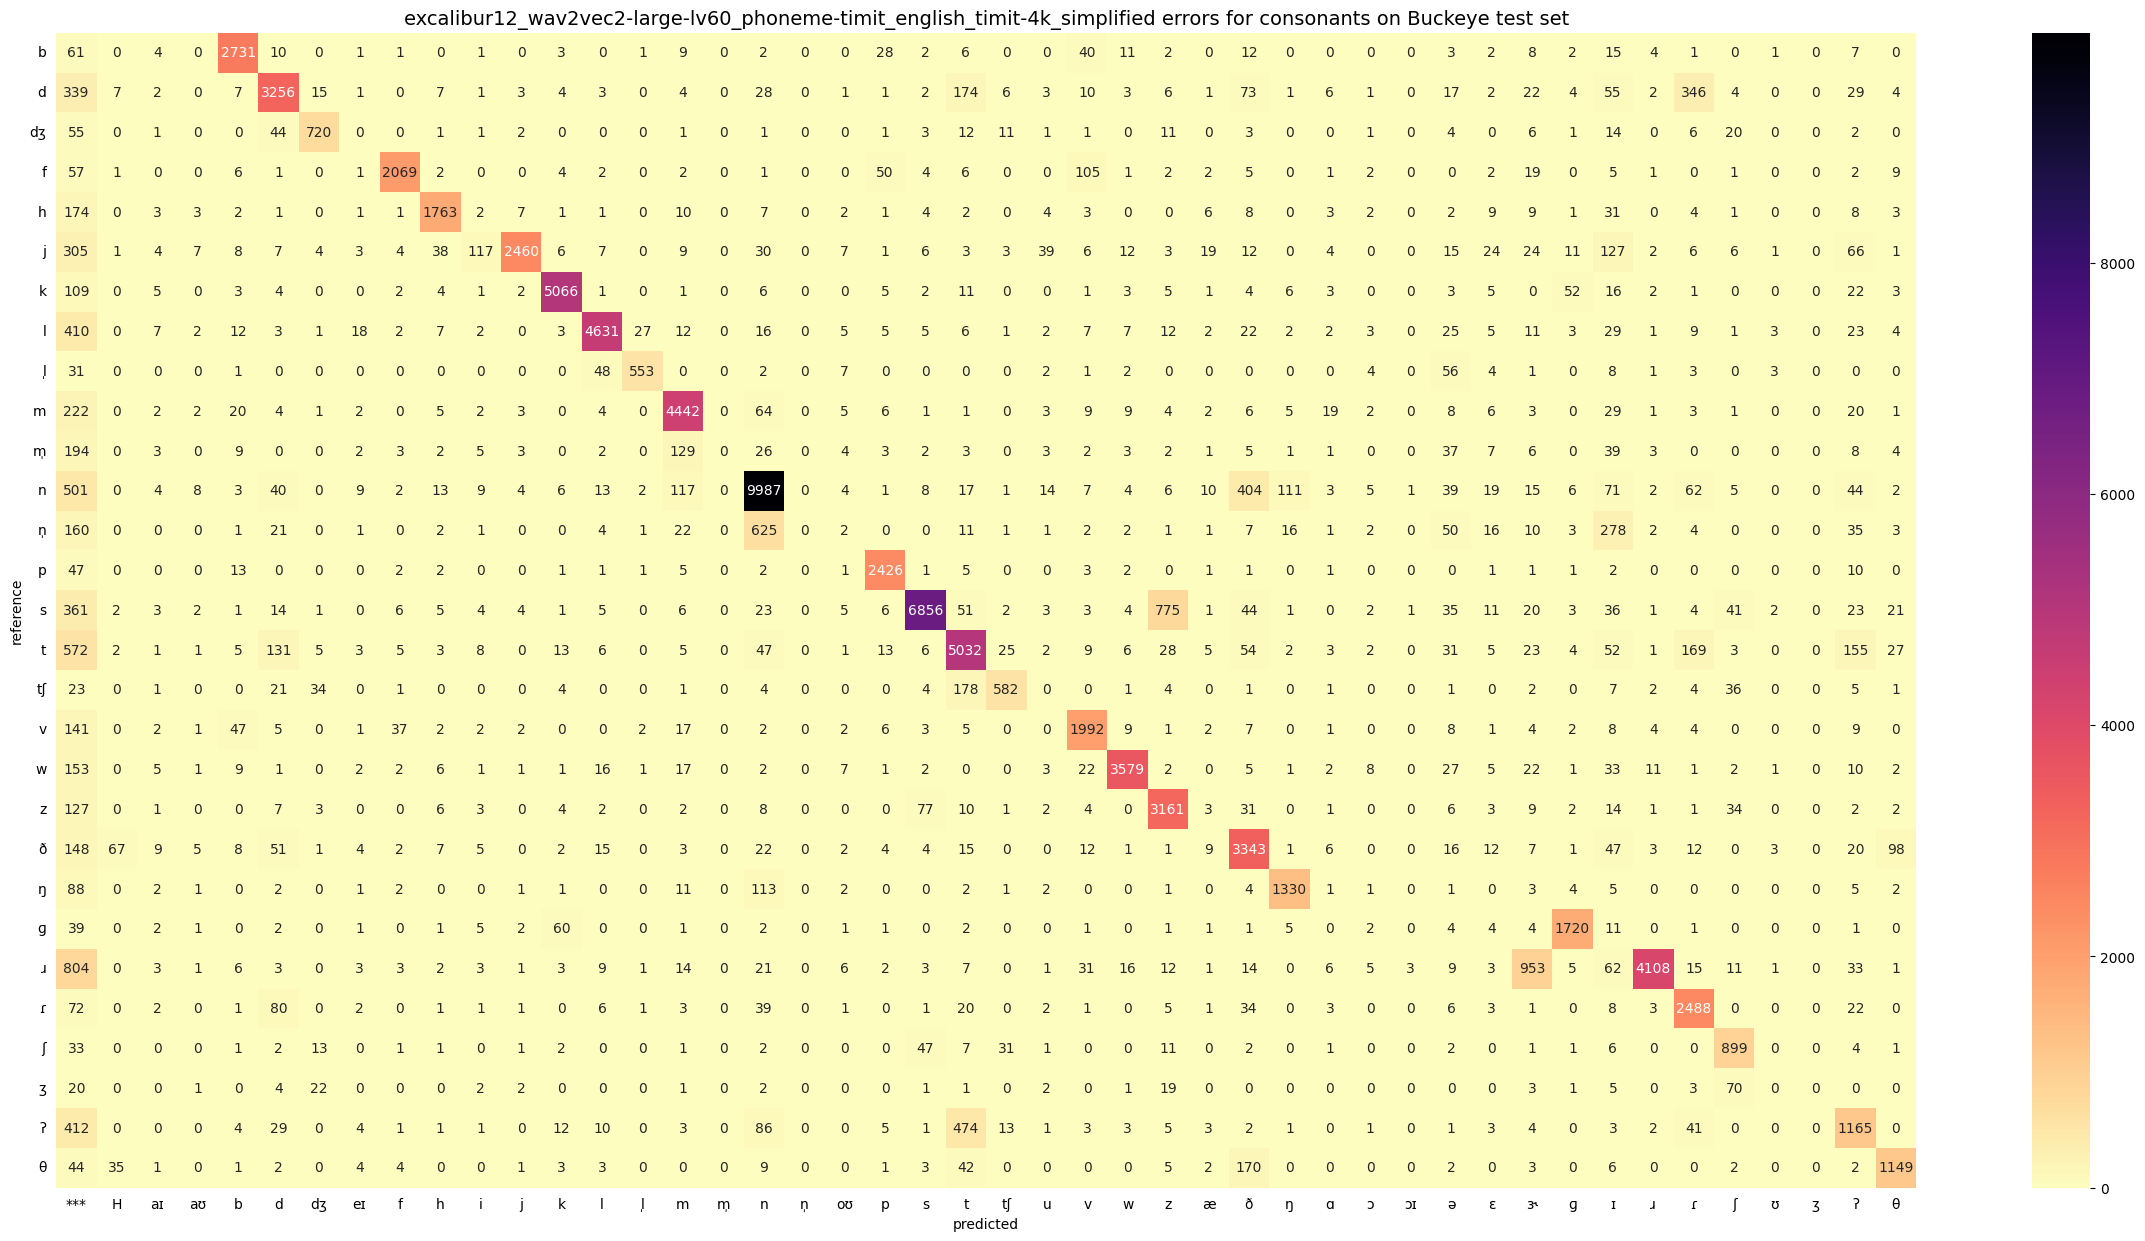

In [19]:
plt.clf()
desired_models_for_conf_matrix = [
    "full_dataset_train_3",
    "train_duration_20000_samples_3",
    "openai_whisper-medium.en_to_epitran",
    "allosaurus_eng2102_eng",
    "facebook_wav2vec2-lv-60-espeak-cv-ft",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified"
]
for mn in desired_models_for_conf_matrix:
    for (label, restriction) in [("vowels", BUCKEYE_VOWELS), ("consonants", BUCKEYE_CONSONANTS)]:
        if mn == "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns":
            figsize = (55, 20)
        elif mn ==    "facebook_wav2vec2-lv-60-espeak-cv-ft":
            figsize = (35, 15)
        else:
            figsize = (30,15)
        plot_token_confusion_matrix(conf_matrices[mn], f"{mn} errors for {label} on Buckeye test set", reference_keys=restriction, figsize=figsize, fmt='.0f', cmap="magma_r")

# Vocabulary item counts in pivot table
Get vocabulary item counts for each model and display them in a pivot table that helps you analyze differences between models. 

In [20]:
token_count_dfs = []
for model_name in desired_models_for_conf_matrix:
    matrix = conf_matrices[model_name]
    print("Model name:", model_name)
    token_count_df = matrix.groupby("predicted")["count"].sum().reset_index()
    token_count_df["model_name"] = model_name
    token_count_dfs.append(token_count_df)

full_token_count_df = pd.concat(token_count_dfs)
full_token_count_df = full_token_count_df[(full_token_count_df["count"] > 0) & (full_token_count_df["predicted"] != EPS)]
display(full_token_count_df.head())


Model name: full_dataset_train_3
Model name: train_duration_20000_samples_3
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified


predicted  count            model_name
7         aɪ   3826  full_dataset_train_3
8         aʊ    826  full_dataset_train_3
9          b   3059  full_dataset_train_3
10         d   4256  full_dataset_train_3
11        dʒ    878  full_dataset_train_3

In [21]:
token_count_pivoted = full_token_count_df.pivot(columns="model_name", index="predicted", values="count")
display(token_count_pivoted)

model_name  allosaurus_eng2102_eng  \
predicted                            
C                              NaN   
H                              NaN   
X                              NaN   
a                           5956.0   
aɪ                            12.0   
aʊ                             1.0   
ä                             NaN   
a͡                             NaN   
a͡a                            NaN   
a͡h                            NaN   
a͡i                            NaN   
a͡n                            NaN   
a͡p                            NaN   
a͡t                            NaN   
a͡ɔ                            NaN   
a͡ɕ                            NaN   
a͡ɛ                            NaN   
a͡ɪ                            NaN   
a͡ʂ                            NaN   
b                           3091.0   
b͡ɪ                            NaN   
c                              NaN   
d                           5935.0   
dʒ                             NaN   
d̪                             NaN   
d͡                             NaN   
d͡a                            NaN   
d͡k                            NaN   
d͡l                            NaN   
d͡t                            NaN   
d͡t͡s                          NaN   
d͡z                            NaN   
d͡ɪ                            NaN   
d͡ʂ                            NaN   
d͡ʑ                            NaN   
d͡ʒ                          830.0   
e                           2977.0   
eɪ                             9.0   
ẽ                             NaN   
e̞                             NaN   
e͡                             NaN   
f                           2084.0   
f͡ɪ                            NaN   
g                              NaN   
h                           2009.0   
i                           5747.0   
i̪                             NaN   
i͡a                            NaN   
i͡i                            NaN   
i͡n                            NaN   
i͡s                            NaN   
i͡u                            NaN   
i͡w                            NaN   
i͡ɛ                            NaN   
i͡ɪ                            NaN   
i͡ʂ                            NaN   
j                          10720.0   
j͡a                            NaN   
j͡o                            NaN   
j͡ɛ                            NaN   
k                           5409.0   
kʲ                             NaN   
k͡r                            NaN   
l                           5772.0   
l̩                             NaN   
m                           4295.0   
m̩                             NaN   
m͡a                            NaN   
m͡ʂ                            NaN   
n                          11110.0   
n̩                             NaN   
n̪                             NaN   
n͡a                            NaN   
n͡e                            NaN   
n͡i                            NaN   
n͡j                            NaN   
n͡n                            NaN   
n͡r                            NaN   
n͡t͡ʃ                          NaN   
n͡ɒ                            NaN   
n͡ɛ                            NaN   
n͡ɛ̃                           NaN   
n͡ʂ                            NaN   
o                           3418.0   
oʊ                             4.0   
õ                             NaN   
o̞                             NaN   
o̞͡ʂ                           NaN   
o͡ɪ                            NaN   
p                           2648.0   
pʲ                             NaN   
q                              NaN   
r                              NaN   
r͡a                            NaN   
r͡i                            NaN   
r͡t͡s                          NaN   
r͡w                            NaN   
r͡ʂ                            NaN   
s                           7549.0   
s͡y                            NaN   
t                          12585.0   
tʃ                            46.0   
t̪                             NaN   
t͡        

In [22]:
token_count_pivoted.to_csv(TOKEN_ANALYSIS_OUTPUT)